# Run torsion scans

In [9]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy

logger = logging.getLogger()
logger.setLevel(logging.INFO)


### Define helper function for running short MD

In [2]:
# outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/5/"
# with open(os.path.join(outdir, "5_vacuum.pickle" ), "rb") as f:
#     htf = pickle.load(f)

# # Define simulation parameters
# temperature = 300 * unit.kelvin
# nsteps = 10000
# timestep = 2.0 * unit.femtosecond
# platform_name = 'CUDA'
# collision_rate = 1.0 / unit.picoseconds

# system = htf.hybrid_system
# positions = htf.hybrid_positions

# # Create CompoundThermodynamicState at the appropriate endstate
# lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
# lambda_protocol = LambdaProtocol(functions = 'default')
# lambda_alchemical_state.set_alchemical_parameters(0, lambda_protocol)
# thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])

# # Set up integrator
# integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# # Set up context
# platform = openmm.Platform.getPlatformByName(platform_name)
# if platform_name in ['CUDA', 'OpenCL']:
#     platform.setPropertyDefaultValue('Precision', 'mixed')
# if platform_name in ['CUDA']:
#     platform.setPropertyDefaultValue('DeterministicForces', 'true')

# context = thermodynamic_state.create_context(integrator, platform=platform)

In [3]:
# swigs = context.getParameters()
# context_parameters = {q: swigs[q] for q in swigs}
# print(context_parameters)


In [10]:
def run_md(htf, endstate):

    # Define simulation parameters
    temperature = 300 * unit.kelvin
    nsteps = 10000
    timestep = 2.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions

    # Create CompoundThermodynamicState at the appropriate endstate
    lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
    lambda_protocol = LambdaProtocol(functions = 'default')
    lambda_alchemical_state.set_alchemical_parameters(endstate, lambda_protocol)
    thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = thermodynamic_state.create_context(integrator, platform=platform)    
#     context, integrator = cache.global_context_cache.get_context(thermodynamic_state, integrator)
#     print(context.getParameter('lambda_angles'))
        
    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(thermodynamic_state.reduced_potential(context))
    
    md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")


    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

    # Run equilibration
    for step in tqdm(range(nsteps)):
        integrator.step(1)
    
    return context, thermodynamic_state

### Sub-class MCDihedralRotationMove

In [11]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [12]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
    d_masses = {}
    # Set particle masses to 0
    for index in hybrid_indices:
        d_masses[index] = htf.hybrid_system.getParticleMass(index)
        htf.hybrid_system.setParticleMass(index, 0.0)
    
    # Turn off constraints involving massless particles
    for i in reversed(range(htf.hybrid_system.getNumConstraints())):
        p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
        if p1 in hybrid_indices or p2 in hybrid_indices:
            if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
                htf.hybrid_system.removeConstraint(i)
    
    # Run MD
    context, thermodynamic_state = run_md(htf, endstate)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(thermodynamic_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(thermodynamic_state, sampler_state)
        
        sampler_state.apply_to_context(context)
#         openmm.LocalEnergyMinimizer.minimize(context)
        energy = thermodynamic_state.reduced_potential(context)
        energies = [energy]
#         sampler_state.update_from_context(context)
        
#         # Apply relaxation move 3x
#         energies = []
#         for i in range(3):
#             relax_move = LangevinSplittingDynamicsMove(timestep=2.0*unit.femtoseconds, collision_rate=1.0/unit.picoseconds, n_steps=10000)
#             relax_move.apply(thermodynamic_state, sampler_state)
#             sampler_state.apply_to_context(context)
#             energy = thermodynamic_state.reduced_potential(context)
#             energies.append(energy)
#             positions = sampler_state.positions

    
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
    # Set masses back to normal
    for index in hybrid_indices:
        thermodynamic_state.system.setParticleMass(index, d_masses[index])
    thermodynamic_state.apply_to_context(context)
    
    return d_corrected
    
    

In [13]:
torsion_scans = []

### Generate torsion scans for the vanilla htf: ALA->THR

In [14]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/5/"
with open(os.path.join(outdir, "5_vacuum.pickle" ), "rb") as f:
    htf_at = pickle.load(f)

#### Look at hybrid and vanilla topologies to determine indices

In [6]:
for atom in htf_at.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB2 11
ALA2-HB3 12
ALA2-C 13
ALA2-O 14
ALA2-HB1 15
ALA2-HB 22
ALA2-CG2 23
ALA2-HG21 24
ALA2-HG22 25
ALA2-HG23 26
ALA2-OG1 27
ALA2-HG1 28
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [7]:
for atom in htf_at._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB2) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB3) of chain 0 residue 1 (ALA)> 12
<Atom 13 (C) of chain 0 residue 1 (ALA)> 13
<Atom 14 (O) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB1) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [8]:
for atom in htf_at._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

  0%|          | 0/10000 [00:00<?, ?it/s]

-77.90257563681348


100%|██████████| 10000/10000 [00:01<00:00, 9235.13it/s]
INFO:root:Rotating by 0.2620000367825073 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000045 radians


1.038905
-87.08475586356525
-118.62206182012166
-116.49056055734124
-113.85737865169544
-112.1688587280089


INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians


-112.67727037977545
-115.05720757774449


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179591 radians
INFO:root:Rotating by 0.2620000000000049 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians


-117.58932253552918
-118.95202020586349
-118.78987561431492
-117.05055045428809
-114.71711771929061


INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians


-113.43063766535161
-114.16203709132478
-116.28565902306082
-118.46812619935491
-119.49261196131647


INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999995 radians
INFO:root:Rotating by 0.26199999999998624 radians
INFO:root:Rotating by 0.2620000000000139 radians


-118.6706599209371
-116.3741007420032
-113.62024299610837
-112.27464495870551
-113.18362945775536


INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26199999999999957 radians


-115.61672372493078
-118.14760903769657
-119.32024064355231
raw d: {1.3009050245285034: (-118.62206182012166, nan), 1.5629050245285034: (-116.49056055734124, nan), 1.8249050245285034: (-113.85737865169544, nan), 2.0869050245285035: (-112.1688587280089, nan), 2.3489050245285035: (-112.67727037977545, nan), 2.6109050245285035: (-115.05720757774449, nan), 2.8729050245285035: (-117.58932253552918, nan), 3.1349050245285035: (-118.95202020586349, nan), -2.8862802826510827: (-118.78987561431492, nan), -2.6242802826510827: (-117.05055045428809, nan), -2.3622802826510827: (-114.71711771929061, nan), -2.1002802826510827: (-113.43063766535161, nan), -1.8382802826510827: (-114.16203709132478, nan), -1.5762802826510827: (-116.28565902306082, nan), -1.3142802826510827: (-118.46812619935491, nan), -1.0522802826510826: (-119.49261196131647, nan), -0.7902802826510826: (-118.6706599209371, nan), -0.5282802826510826: (-116.3741007420032, nan), -0.2662802826510826: (-113.62024299610837, nan), -0.004280282

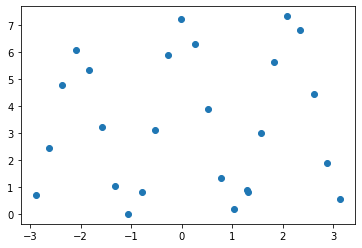

In [15]:
# ALA->THR -- ALA at lambda = 0
run_torsion_scan(htf_at, 0, True, [6, 8, 10, 15], [6, 8, 10, 15], [11, 12])

 10%|▉         | 992/10000 [00:00<00:00, 9918.14it/s]

-77.90257563681348


100%|██████████| 10000/10000 [00:00<00:00, 12599.92it/s]
INFO:root:Rotating by 0.2620000870596926 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26199999999999984 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2619999999999981 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:roo

-1.1785822
-55.22245288273347
-50.242571783687794
-43.425865632515084
-36.443490330866645
-32.010083882861025
-32.459600812688166
-37.75346732588688
-45.4833563522977
-52.84951416862261
-58.07566384335237
-60.69731527491249
-61.53053726425656
-62.35733913791588
-64.79749254975322
-68.87166911598216
-72.94870952641526
-75.15106298417643
-74.5313084871597
-71.35725449868326
-66.89679213703405
-62.84837051103356
-60.356858540595084
-59.180836021554995
-57.93467475395412
-55.1517072870494


INFO:root:Rotating by 0.26200000000000045 radians


raw d: {-0.9165821914672851: (-50.242571783687794, nan), -0.6545821914672851: (-43.425865632515084, nan), -0.3925821914672851: (-36.443490330866645, nan), -0.1305821914672851: (-32.010083882861025, nan), 0.1314178085327149: (-32.459600812688166, nan), 0.3934178085327149: (-37.75346732588688, nan), 0.6554178085327149: (-45.4833563522977, nan), 0.9174178085327149: (-52.84951416862261, nan), 1.179417808532715: (-58.07566384335237, nan), 1.441417808532715: (-60.69731527491249, nan), 1.703417808532715: (-61.53053726425656, nan), 1.965417808532715: (-62.35733913791588, nan), 2.227417808532715: (-64.79749254975322, nan), 2.489417808532715: (-68.87166911598216, nan), 2.751417808532715: (-72.94870952641526, nan), 3.013417808532715: (-75.15106298417643, nan), -3.007767498646871: (-74.5313084871597, nan), -2.745767498646871: (-71.35725449868326, nan), -2.483767498646871: (-66.89679213703405, nan), -2.221767498646871: (-62.84837051103356, nan), -1.9597674986468712: (-60.356858540595084, nan), -1.6

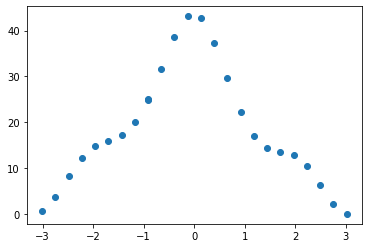

In [15]:
# ALA->THR -- THR at lambda = 0
# run_torsion_scan(htf_at, 0, False, [6, 8, 10, 27], [6, 8, 10, 18], [22, 23, 24, 25, 26, 28])
torsion_scans.append(run_torsion_scan(htf_at, 0, False, [6, 8, 10, 27], [6, 8, 10, 18], [22, 23, 24, 25, 26, 28]))

 10%|▉         | 998/10000 [00:00<00:00, 9978.75it/s]

178.98917879703816


100%|██████████| 10000/10000 [00:01<00:00, 9293.02it/s]
INFO:root:Rotating by 0.2620000870596926 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26199999999999984 radians


-1.1785822
-32.59405292181928
-65.05190247710576
-64.7642799395197
-61.77223254259721


INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2619999999999981 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.26200000000000034 radians


-57.64560397335647
-59.440090759976336
-63.69911955112693
-69.51078739165963


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians


-72.83370364517796
-72.7919110654393
-69.5503472224921


INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians


-64.26682110769926
-58.270768424854836
-52.50655510793644


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians


-56.52085182710601
-61.83646469248955
-65.36662834508459


INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians


-65.9866613541206
-63.48293862008125
-58.68316636924304
-49.41240980614115


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000045 radians


-51.04555360472352
-53.80009394022006
-58.11521507712738
-62.5864013042123
raw d: {-0.9165821914672851: (-65.05190247710576, nan), -0.6545821914672851: (-64.7642799395197, nan), -0.3925821914672851: (-61.77223254259721, nan), -0.1305821914672851: (-57.64560397335647, nan), 0.1314178085327149: (-59.440090759976336, nan), 0.3934178085327149: (-63.69911955112693, nan), 0.6554178085327149: (-69.51078739165963, nan), 0.9174178085327149: (-72.83370364517796, nan), 1.179417808532715: (-72.7919110654393, nan), 1.441417808532715: (-69.5503472224921, nan), 1.703417808532715: (-64.26682110769926, nan), 1.965417808532715: (-58.270768424854836, nan), 2.227417808532715: (-52.50655510793644, nan), 2.489417808532715: (-56.52085182710601, nan), 2.751417808532715: (-61.83646469248955, nan), 3.013417808532715: (-65.36662834508459, nan), -3.007767498646871: (-65.9866613541206, nan), -2.745767498646871: (-63.48293862008125, nan), -2.483767498646871: (-58.68316636924304, nan), -2.221767498646871: (-49.41240

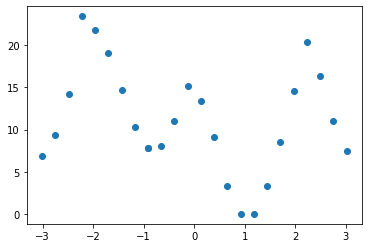

In [17]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf_at, 1, False, [6, 8, 10, 27], [6, 8, 10, 18], [22, 23, 24, 25, 26, 28])

  9%|▊         | 856/10000 [00:00<00:01, 8558.99it/s]

178.98917879703816


100%|██████████| 10000/10000 [00:01<00:00, 9253.23it/s]
INFO:root:Rotating by 0.2620000367825073 radians


1.038905
-34.49951765083483


INFO:root:Rotating by 0.262 radians


-67.74487147325814


INFO:root:Rotating by 0.26199999999999957 radians


-65.6749305202419


INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000045 radians


-63.242858596591255
-61.76551827882093


INFO:root:Rotating by 0.26199999999999957 radians


-62.62995148519686


INFO:root:Rotating by 0.262 radians


-64.79321205530808


INFO:root:Rotating by 0.262 radians


-67.18931797002907


INFO:root:Rotating by -6.021185307179591 radians


-68.29550931801855


INFO:root:Rotating by 0.2620000000000049 radians


-67.92795079482381


INFO:root:Rotating by 0.26199999999999957 radians


-66.16218949345281


INFO:root:Rotating by 0.262 radians


-63.986034337817486


INFO:root:Rotating by 0.26200000000000045 radians


-62.696973089513975


INFO:root:Rotating by 0.26199999999999934 radians


-63.59740505532478


INFO:root:Rotating by 0.2619999999999998 radians


-65.68534542083096


INFO:root:Rotating by 0.2619999999999998 radians


-67.79383555500448


INFO:root:Rotating by 0.26200000000000045 radians


-68.68815066931423


INFO:root:Rotating by 0.2619999999999997 radians


-67.95308057499648


INFO:root:Rotating by 0.2620000000000001 radians


-65.73421276056486


INFO:root:Rotating by 0.2619999999999995 radians


-63.05604934428089


INFO:root:Rotating by 0.26199999999998624 radians


-61.718492209682296


INFO:root:Rotating by 0.2620000000000139 radians


-62.64735219995144


INFO:root:Rotating by 0.26200000000000045 radians


-65.09266405155186


INFO:root:Rotating by 0.2619999999999997 radians


-67.395225301271


INFO:root:Rotating by 0.26199999999999957 radians


-68.3574041903258
raw d: {1.3009050245285034: (-67.74487147325814, nan), 1.5629050245285034: (-65.6749305202419, nan), 1.8249050245285034: (-63.242858596591255, nan), 2.0869050245285035: (-61.76551827882093, nan), 2.3489050245285035: (-62.62995148519686, nan), 2.6109050245285035: (-64.79321205530808, nan), 2.8729050245285035: (-67.18931797002907, nan), 3.1349050245285035: (-68.29550931801855, nan), -2.8862802826510827: (-67.92795079482381, nan), -2.6242802826510827: (-66.16218949345281, nan), -2.3622802826510827: (-63.986034337817486, nan), -2.1002802826510827: (-62.696973089513975, nan), -1.8382802826510827: (-63.59740505532478, nan), -1.5762802826510827: (-65.68534542083096, nan), -1.3142802826510827: (-67.79383555500448, nan), -1.0522802826510826: (-68.68815066931423, nan), -0.7902802826510826: (-67.95308057499648, nan), -0.5282802826510826: (-65.73421276056486, nan), -0.2662802826510826: (-63.05604934428089, nan), -0.004280282651082601: (-61.718492209682296, nan), 0.257719717348917

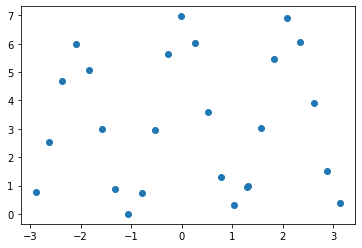

In [18]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf_at, 1, True, [6, 8, 10, 15], [6, 8, 10, 15], [11, 12])

### Generate torsion scans for the vanilla htf: THR->ALA (with sidechains mapped)

In [69]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/6/"
with open(os.path.join(outdir, "6_vacuum.pickle" ), "rb") as f:
    htf_ta = pickle.load(f)
htf_ta_0t = copy.copy(htf_ta)
htf_ta_0a = copy.copy(htf_ta)
htf_ta_1a = copy.copy(htf_ta)
htf_ta_1t = copy.copy(htf_ta)

#### Look at hybrid topology to determine indices

In [6]:
for atom in htf_ta.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
THR2-HB2 26
THR2-HB3 27
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [30]:
for atom in htf_ta._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [25]:
for atom in htf_ta._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (C) of chain 0 residue 1 (ALA)> 11
<Atom 12 (O) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


100%|██████████| 10000/10000 [00:00<00:00, 11125.14it/s]
INFO:root:Rotating by -6.021185302286687 radians


3.0743732
-35.756116376793685


INFO:root:Rotating by 0.26200000000000356 radians


-39.08929778531802


INFO:root:Rotating by 0.2619999999999969 radians


-31.804325408215924


INFO:root:Rotating by 0.26199999999999735 radians


-27.31039689827153


INFO:root:Rotating by 0.26199999999999735 radians


-29.737210998945617


INFO:root:Rotating by 0.2620000000000009 radians


-28.46920437180947


INFO:root:Rotating by 0.26200000000000156 radians


-24.30949640169366


INFO:root:Rotating by 0.2620000000000047 radians


-40.40934351322722


INFO:root:Rotating by 0.26199999999999846 radians


-39.28131002910503


INFO:root:Rotating by 0.2620000000000027 radians


-28.06943389580796


INFO:root:Rotating by 0.26200000000000234 radians


-31.90497155548382


INFO:root:Rotating by 0.2620000000000036 radians


-42.27235331838381


INFO:root:Rotating by 0.2620000000000002 radians


-26.613713836435558


INFO:root:Rotating by 0.262 radians


-22.40864595399778


INFO:root:Rotating by 0.26200000000000245 radians


-24.894221139143692


INFO:root:Rotating by 0.2619999999999981 radians


-35.18663387951964


INFO:root:Rotating by 0.26200000000000323 radians


-44.17067546105189


INFO:root:Rotating by 0.26199999999999957 radians


-37.775680329472394


INFO:root:Rotating by 0.2620000000000007 radians


-43.67837113260111


INFO:root:Rotating by 0.26199999999999646 radians


-21.92005668577586


INFO:root:Rotating by 0.26200000000000045 radians


-25.484548674441697


INFO:root:Rotating by 0.2620000000000027 radians


-13.14561270430761


INFO:root:Rotating by 0.2619999999999969 radians


-30.972895991005657


INFO:root:Rotating by 0.2619999999999987 radians


-23.922519248182866


INFO:root:Rotating by -6.0211853071795876 radians


-32.127424994776696
raw d: {-2.9468120619403284: (-33.05131048373905, 5.952063067602909), -2.6848120619403284: (-30.036429726495882, 3.238562069959711), -2.4228120619403284: (-31.298420944177206, 3.3309664950585995), -2.1608120619403284: (-29.288790363793506, 0.9139881881138215), -1.8988120619403284: (-24.86436453515581, 1.9489907890613642), -1.6368120619403284: (-28.48501703681586, 2.612604524732355), -1.3748120619403283: (-37.890814209283015, 2.5554913167207336), -1.1128120619403283: (-38.0376031973399, 0.8944895180154032), -0.8508120619403283: (-27.69357458259125, 1.6235645029432602), -0.5888120619403283: (-37.036219003035875, 4.696350477462528), -0.3268120619403283: (-34.576105038750946, 3.872177156608601), -0.06481206194032829: (-23.229802528427683, 2.8143645380269646), 0.19718793805967172: (-25.072876663913636, 1.5997791821875174), 0.45918793805967173: (-25.85287548120881, 4.015101153213349), 0.7211879380596717: (-33.323358695158674, 2.251279165565071), 0.9831879380596718: (-43.4

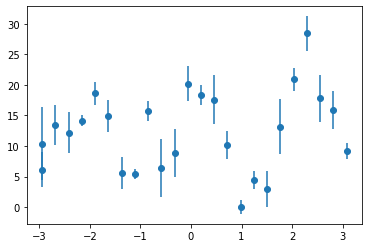

In [47]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(htf_ta_0t, 0, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19])

100%|██████████| 10000/10000 [00:00<00:00, 12929.97it/s]


-1.2834105
-32.7543590257392


INFO:root:Rotating by 0.2620004455520788 radians
INFO:root:Rotating by 0.2620000000000009 radians


-44.318559617809754


INFO:root:Rotating by 0.26199999999999957 radians


-44.99400516408182


INFO:root:Rotating by 0.2619999999999987 radians


-35.91066865090166


INFO:root:Rotating by 0.26200000000000084 radians


-28.12939151881853


INFO:root:Rotating by 0.26200000000000234 radians


-31.19819753815188


INFO:root:Rotating by 0.262 radians


-32.5541629566863


INFO:root:Rotating by 0.26199999999999946 radians


-23.315085939516027


INFO:root:Rotating by 0.2620000000000007 radians


-35.7124960815244


INFO:root:Rotating by 0.26200000000000623 radians


-40.181614264062006


INFO:root:Rotating by 0.2619999999999998 radians


-38.20798615370681


INFO:root:Rotating by 0.2619999999999991 radians


-29.47537472919283


INFO:root:Rotating by 0.26200000000000667 radians


-27.97939302426207


INFO:root:Rotating by 0.26200000000000623 radians


-21.03154346122075


INFO:root:Rotating by 0.26199999999999823 radians


-30.10862931728065


INFO:root:Rotating by 0.2619999999999978 radians


-33.728452780073596


INFO:root:Rotating by -6.02118530717959 radians


-48.85336829597171


INFO:root:Rotating by 0.2619999999999987 radians


-41.93408149939506


INFO:root:Rotating by 0.262000000000004 radians


-39.36445404780385


INFO:root:Rotating by 0.2620000000000018 radians


-31.261913653494084


INFO:root:Rotating by 0.26199999999999957 radians


-27.871990666225546


INFO:root:Rotating by 0.2620000000000027 radians


-24.78778682776295


INFO:root:Rotating by 0.26200000000000223 radians


-26.0077611439492


INFO:root:Rotating by 0.26200000000000023 radians


-25.375842064774744


INFO:root:Rotating by 0.26199999999999357 radians


-40.295227157975845
raw d: {-1.0214105491638183: (-45.81316703680619, 0.8086845641960869), -0.7594105491638183: (-38.813058755595584, 3.8995604458141373), -0.4974105491638183: (-36.326350674794035, 1.441508219009039), -0.23541054916381832: (-27.049341396122873, 2.043278343738713), 0.026589450836181694: (-28.642387553251535, 2.1679549587544553), 0.2885894508361817: (-36.4694205989361, 2.2449666111499273), 0.5505894508361817: (-28.240088501915665, 2.910080779425687), 0.8125894508361817: (-33.93239949041949, 1.2730095989851749), 1.0745894508361817: (-35.38943684945435, 2.736708440528919), 1.3365894508361817: (-33.69332898023953, 2.3443459942271865), 1.5985894508361818: (-33.874432371381516, 2.8913842045378857), 1.8605894508361818: (-28.08758696280874, 1.2905906160345024), 2.122589450836182: (-24.065498084356104, 3.5976828027615135), 2.384589450836182: (-30.559813825696068, 0.9295144091502314), 2.646589450836182: (-35.1248350055643, 1.6511840782884797), 2.908589450836182: (-46.885621281428

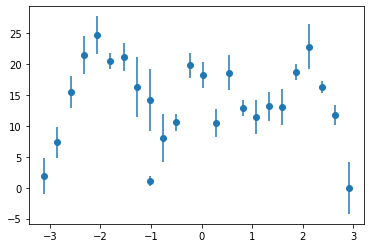

In [50]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(htf_ta_0a, 0, False, [6, 8, 10, 13], [6, 8, 10, 13], [26, 27])

100%|██████████| 10000/10000 [00:00<00:00, 11551.51it/s]
INFO:root:Rotating by 0.2620004455520788 radians


-1.2834105
-68.29725119134353


INFO:root:Rotating by 0.2620000000000009 radians


-80.83755327733064


INFO:root:Rotating by 0.26199999999999957 radians


-80.22582994312683


INFO:root:Rotating by 0.2619999999999987 radians


-74.35798646784595


INFO:root:Rotating by 0.26200000000000084 radians


-75.00815257182798


INFO:root:Rotating by 0.26200000000000234 radians


-67.15261153984586


INFO:root:Rotating by 0.262 radians


-62.31583934232596


INFO:root:Rotating by 0.26199999999999946 radians


-62.243704911764915


INFO:root:Rotating by 0.2620000000000007 radians


-66.63596742038372


INFO:root:Rotating by 0.26200000000000623 radians


-48.64007606123569


INFO:root:Rotating by 0.2619999999999998 radians


-70.35929913731154


INFO:root:Rotating by 0.2619999999999991 radians


-29.50925757341764


INFO:root:Rotating by 0.26200000000000667 radians


-37.55186621150963


INFO:root:Rotating by 0.26200000000000623 radians


-50.87081880559397


INFO:root:Rotating by 0.26199999999999823 radians


-31.201233425579673


INFO:root:Rotating by 0.2619999999999978 radians


-52.23667598768488


INFO:root:Rotating by -6.02118530717959 radians


-59.47440298632474


INFO:root:Rotating by 0.2619999999999987 radians


-62.06345210617634


INFO:root:Rotating by 0.262000000000004 radians


-66.95338982837187


INFO:root:Rotating by 0.2620000000000018 radians


-62.723448394183706


INFO:root:Rotating by 0.26199999999999957 radians


-66.58114244960223


INFO:root:Rotating by 0.2620000000000027 radians


-62.81297732451018


INFO:root:Rotating by 0.26200000000000223 radians


-59.21143675868611


INFO:root:Rotating by 0.26200000000000023 radians


-74.86528609216501


INFO:root:Rotating by 0.26199999999999357 radians


-86.62646955571387
raw d: {-1.0214105491638183: (-84.81861591537772, 5.86061158511796), -0.7594105491638183: (-82.4191235784356, 1.8367426460520093), -0.4974105491638183: (-79.94174968561771, 2.8970498886953346), -0.23541054916381832: (-69.41601638937448, 6.475471751354084), 0.026589450836181694: (-67.33622361451097, 4.000050474610061), 0.2885894508361817: (-60.99912983109423, 1.1482075598627226), 0.5505894508361817: (-59.18611094376393, 2.3056832396826685), 0.8125894508361817: (-64.92694640516906, 1.0660192358644636), 1.0745894508361817: (-56.89715872641526, 4.734318545439626), 1.3365894508361817: (-59.637137795827606, 5.4302782098881766), 1.5985894508361818: (-45.03724409206681, 8.09928102122475), 1.8605894508361818: (-37.356231485293705, 2.776900276766356), 2.122589450836182: (-43.345202885057724, 7.02039844999774), 2.384589450836182: (-36.36580187940125, 3.2722563361987937), 2.646589450836182: (-53.85666051423369, 2.260308488782393), 2.908589450836182: (-57.281037967283886, 2.50688

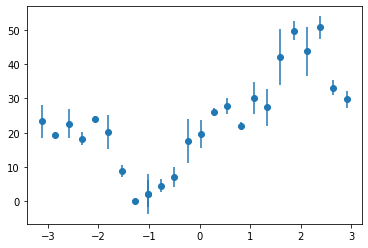

In [54]:
# THR->ALA -- ALA at lambda = 1
run_torsion_scan(htf_ta_0a, 1, False,  [6, 8, 10, 13], [6, 8, 10, 13], [26, 27])

100%|██████████| 10000/10000 [00:00<00:00, 13473.43it/s]
INFO:root:Rotating by -6.021185302286687 radians


3.0743732
-83.75519411369169


INFO:root:Rotating by 0.26200000000000356 radians


-83.29955821036533


INFO:root:Rotating by 0.2619999999999969 radians


-82.37588196678409


INFO:root:Rotating by 0.26199999999999735 radians


-74.59358873022593


INFO:root:Rotating by 0.26199999999999735 radians


-57.24260653438681


INFO:root:Rotating by 0.2620000000000009 radians


-58.746096259363235


INFO:root:Rotating by 0.26200000000000156 radians


-58.15669189267001


INFO:root:Rotating by 0.2620000000000047 radians


-67.44612145635335


INFO:root:Rotating by 0.26199999999999846 radians


-57.77846990313089


INFO:root:Rotating by 0.2620000000000027 radians


-58.28270000892311


INFO:root:Rotating by 0.26200000000000234 radians


-53.0134530717732


INFO:root:Rotating by 0.2620000000000036 radians


-35.52576136519777


INFO:root:Rotating by 0.2620000000000002 radians


-39.88874682477465


INFO:root:Rotating by 0.262 radians


-33.83519914218746


INFO:root:Rotating by 0.26200000000000245 radians


-35.736457018307036


INFO:root:Rotating by 0.2619999999999981 radians


-57.68143794223418


INFO:root:Rotating by 0.26200000000000323 radians


-70.61693968602562


INFO:root:Rotating by 0.26199999999999957 radians


-63.770208022924386


INFO:root:Rotating by 0.2620000000000007 radians


-62.97799759576755


INFO:root:Rotating by 0.26199999999999646 radians


-61.26974556785078


INFO:root:Rotating by 0.26200000000000045 radians


-53.69973955042587


INFO:root:Rotating by 0.2620000000000027 radians


-66.16192403101161


INFO:root:Rotating by 0.2619999999999969 radians


-79.6520653158641


INFO:root:Rotating by 0.2619999999999987 radians


-70.91715367054272


INFO:root:Rotating by -6.0211853071795876 radians


-85.91800053653348
raw d: {-2.9468120619403284: (-78.0237645511412, 2.655083993881097), -2.6848120619403284: (-84.11516747703304, 0.9615499893632607), -2.4228120619403284: (-73.6644682220841, 2.0570858247066655), -2.1608120619403284: (-60.31009936975905, 2.4854292880979107), -1.8988120619403284: (-63.52101825401106, 2.4579406809184525), -1.6368120619403284: (-54.83453379570668, 1.9033077851393607), -1.3748120619403283: (-63.513431273546665, 4.23651273155393), -1.1128120619403283: (-56.71845916610378, 0.8734282265376853), -0.8508120619403283: (-54.29929743428397, 3.347698835818648), -0.5888120619403283: (-53.55126635018076, 1.6517595934562839), -0.3268120619403283: (-30.49227093022091, 3.16812924272601), -0.06481206194032829: (-36.69534580648598, 2.3290778161643746), 0.19718793805967172: (-29.36013106354342, 4.1677645511509605), 0.45918793805967173: (-37.945547109010974, 5.877467557311895), 0.7211879380596717: (-51.4372228095447, 3.148772420419375), 0.9831879380596718: (-65.476655870512

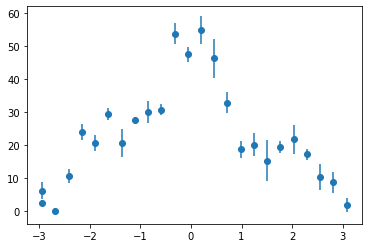

In [55]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(htf_ta_0t, 1, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19])

### Generate torsions scans for htfs with flattened torsions (and sidechains not mapped): ALA->THR

In [16]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/31/"
with open(os.path.join(outdir, "31_vacuum.pickle" ), "rb") as f:
    htf_at = pickle.load(f)
htf_at_0a = copy.copy(htf_at)
htf_at_0t = copy.copy(htf_at)
htf_at_1t = copy.copy(htf_at)
htf_at_1a = copy.copy(htf_at)

#### Look at hybrid and vanilla topologies to determine indices

In [20]:
for atom in htf_at.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [21]:
for atom in htf_at._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [22]:
for atom in htf_at._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

  0%|          | 0/10000 [00:00<?, ?it/s]

-110.73761849033873


100%|██████████| 10000/10000 [00:02<00:00, 4644.61it/s]


1.0471988
-84.00163083508382


INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians


-108.87600892368982


INFO:root:Rotating by 0.2619999999999998 radians


-107.3170762822728


INFO:root:Rotating by 0.26199999999999957 radians


-105.03834556548752


INFO:root:Rotating by 0.26200000000000045 radians


-103.0782358895191


INFO:root:Rotating by 0.262 radians


-102.00778188793258


INFO:root:Rotating by 0.26200000000000045 radians


-104.05615146986361


INFO:root:Rotating by -6.021185307179586 radians


-106.7457207995591


INFO:root:Rotating by 0.2620000000000111 radians


-108.48518099746299


INFO:root:Rotating by 0.2619999999999889 radians


-108.71149373174276


INFO:root:Rotating by 0.26199999999999957 radians


-107.55477169638446


INFO:root:Rotating by 0.262 radians


-105.54252643092909


INFO:root:Rotating by 0.262 radians


-104.34781760239724


INFO:root:Rotating by 0.262 radians


-104.1645653046974


INFO:root:Rotating by 0.2619999999999998 radians


-105.40810523296773


INFO:root:Rotating by 0.262 radians


-107.12802944683898


INFO:root:Rotating by 0.26200000000000023 radians


-108.24482333731207


INFO:root:Rotating by 0.26200000000000023 radians


-108.01394816244606


INFO:root:Rotating by 0.2619999999999999 radians


-106.55054530471737


INFO:root:Rotating by 0.26200000000000023 radians


-104.59270774186469


INFO:root:Rotating by 0.26200000000000323 radians


-103.33430609547335


INFO:root:Rotating by 0.2619999999999972 radians


-103.65546220456979


INFO:root:Rotating by 0.26199999999999946 radians


-105.34191164795395


INFO:root:Rotating by 0.2619999999999999 radians


-107.430096553907


INFO:root:Rotating by 0.26200000000000045 radians


-108.81072733205585
raw d: {1.30919877243042: (-108.87600892368982, nan), 1.57119877243042: (-107.3170762822728, nan), 1.83319877243042: (-105.03834556548752, nan), 2.09519877243042: (-103.0782358895191, nan), 2.35719877243042: (-102.00778188793258, nan), 2.61919877243042: (-104.05615146986361, nan), 2.88119877243042: (-106.7457207995591, nan), -3.1399865347491662: (-108.48518099746299, nan), -2.877986534749166: (-108.71149373174276, nan), -2.615986534749166: (-107.55477169638446, nan), -2.353986534749166: (-105.54252643092909, nan), -2.091986534749166: (-104.34781760239724, nan), -1.8299865347491662: (-104.1645653046974, nan), -1.5679865347491662: (-105.40810523296773, nan), -1.3059865347491662: (-107.12802944683898, nan), -1.0439865347491661: (-108.24482333731207, nan), -0.7819865347491661: (-108.01394816244606, nan), -0.5199865347491661: (-106.55054530471737, nan), -0.2579865347491661: (-104.59270774186469, nan), 0.004013465250833903: (-103.33430609547335, nan), 0.2660134652508339: 

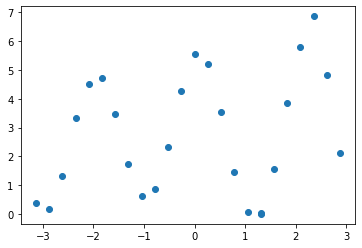

In [23]:
# ALA->THR -- ALA at lambda = 0
run_torsion_scan(htf_at_0a, 0, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13])

  0%|          | 0/10000 [00:00<?, ?it/s]

-110.73761849033873


100%|██████████| 10000/10000 [00:02<00:00, 4725.76it/s]


2.7912235
-86.64674122772


INFO:root:Rotating by 0.2620000119779138 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2620000000000008 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rota

-88.52396930723033
-87.84294421551584
-85.26269631320984
-81.53783021041897
-77.6168803726178
-74.38075745811935
-71.83396755715484
-69.17299358692013
-65.72164554394759
-61.313254664270126
-56.20315131962319
-51.37096717496549
-48.81181891754586
-50.28648031787073
-55.35771069093634
-61.88500036210418
-68.02840782039769
-72.7556982921967
-75.37821019150321
-75.8635527755499
-75.87027382672031
-77.99886705978214
-82.48989251115394
-86.70580769820569
raw d: {3.0532235260009766: (-88.52396930723033, nan), -2.9679617811786096: (-87.84294421551584, nan), -2.7059617811786096: (-85.26269631320984, nan), -2.4439617811786096: (-81.53783021041897, nan), -2.1819617811786096: (-77.6168803726178, nan), -1.9199617811786096: (-74.38075745811935, nan), -1.6579617811786096: (-71.83396755715484, nan), -1.3959617811786096: (-69.17299358692013, nan), -1.1339617811786096: (-65.72164554394759, nan), -0.8719617811786096: (-61.313254664270126, nan), -0.6099617811786096: (-56.20315131962319, nan), -0.34796178

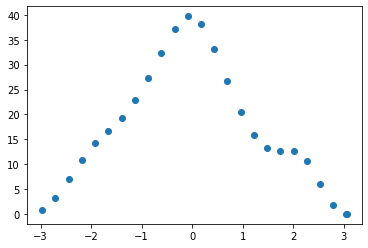

In [17]:
# ALA->THR -- THR at lambda = 0
torsion_scans.append(run_torsion_scan(htf_at_0t, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]))

26.18438522599787


100%|██████████| 10000/10000 [00:01<00:00, 5600.82it/s]
INFO:root:Rotating by 0.2620000119779138 radians
INFO:root:Rotating by -6.021185307179586 radians


2.7912235
39.22850403369243
-2.1766170715949484


INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians


-5.404586659231063
-4.799388737439432


INFO:root:Rotating by 0.262 radians


-1.3506668721669342


INFO:root:Rotating by 0.26199999999999957 radians


2.0262392177501156


INFO:root:Rotating by 0.262 radians


4.065333168619341


INFO:root:Rotating by 0.2619999999999998 radians


3.958829244976378


INFO:root:Rotating by 0.2619999999999998 radians


43.79646965714233


INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians


4.313561137309439
7.648970845523436


INFO:root:Rotating by 0.26200000000000057 radians


13.966647906890588


INFO:root:Rotating by 0.2619999999999998 radians


21.71147735078571


INFO:root:Rotating by 0.26200000000000045 radians


27.421711785805808


INFO:root:Rotating by 0.2620000000000008 radians


27.911820563861685


INFO:root:Rotating by 0.26199999999999934 radians


26.057077186214308


INFO:root:Rotating by 0.26200000000000057 radians


22.737236972951823


INFO:root:Rotating by 0.2619999999999998 radians


19.509681105085406


INFO:root:Rotating by 0.262 radians


18.165880781384452


INFO:root:Rotating by 0.2619999999999998 radians


18.779039097678506


INFO:root:Rotating by 0.26200000000000023 radians


19.912352046150247


INFO:root:Rotating by 0.26199999999999957 radians


20.239116657335217


INFO:root:Rotating by 0.262 radians


17.29549276355504


INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26199999999999957 radians


11.134412835812288
3.693695316707123
raw d: {3.0532235260009766: (-2.1766170715949484, nan), -2.9679617811786096: (-5.404586659231063, nan), -2.7059617811786096: (-4.799388737439432, nan), -2.4439617811786096: (-1.3506668721669342, nan), -2.1819617811786096: (2.0262392177501156, nan), -1.9199617811786096: (4.065333168619341, nan), -1.6579617811786096: (3.958829244976378, nan), -1.3959617811786096: (43.79646965714233, nan), -1.1339617811786096: (4.313561137309439, nan), -0.8719617811786096: (7.648970845523436, nan), -0.6099617811786096: (13.966647906890588, nan), -0.34796178117860954: (21.71147735078571, nan), -0.08596178117860953: (27.421711785805808, nan), 0.17603821882139048: (27.911820563861685, nan), 0.4380382188213905: (26.057077186214308, nan), 0.7000382188213905: (22.737236972951823, nan), 0.9620382188213905: (19.509681105085406, nan), 1.2240382188213905: (18.165880781384452, nan), 1.4860382188213905: (18.779039097678506, nan), 1.7480382188213905: (19.912352046150247, nan), 2.01

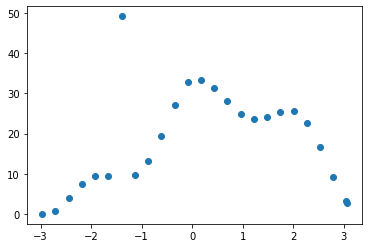

In [36]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf_at_1t, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29])

26.18438522599787


100%|██████████| 10000/10000 [00:01<00:00, 5376.47it/s]
INFO:root:Rotating by 0.26199995022480693 radians


1.0471988
-11.36393803816873


INFO:root:Rotating by 0.2619999999999998 radians


-41.52693728266666


INFO:root:Rotating by 0.2619999999999998 radians


-40.71123442664667


INFO:root:Rotating by 0.26199999999999957 radians


-40.374733852688664


INFO:root:Rotating by 0.26200000000000045 radians


-40.00295162284753


INFO:root:Rotating by 0.262 radians


-39.991481422821394


INFO:root:Rotating by 0.26200000000000045 radians


-39.96253834617024


INFO:root:Rotating by -6.021185307179586 radians


-40.418764897604866


INFO:root:Rotating by 0.2620000000000111 radians


-40.687981010314864


INFO:root:Rotating by 0.2619999999999889 radians


-41.22750383422204


INFO:root:Rotating by 0.26199999999999957 radians


-41.4453078168049


INFO:root:Rotating by 0.262 radians


-41.834044108916515


INFO:root:Rotating by 0.262 radians


-42.86382230284378


INFO:root:Rotating by 0.262 radians


-42.37149357398409


INFO:root:Rotating by 0.2619999999999998 radians


-42.608990141069754


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians


-42.94586622265525
-42.818071696845884


INFO:root:Rotating by 0.26200000000000023 radians


-42.70555330190488


INFO:root:Rotating by 0.2619999999999999 radians


-42.32172653917236


INFO:root:Rotating by 0.26200000000000023 radians


-41.972502037014465


INFO:root:Rotating by 0.26200000000000323 radians


-42.40892761679727


INFO:root:Rotating by 0.2619999999999972 radians


-42.0243237725755


INFO:root:Rotating by 0.26199999999999946 radians


-42.21379688622531


INFO:root:Rotating by 0.2619999999999999 radians


-42.193804925296895


INFO:root:Rotating by 0.26200000000000045 radians


-41.88187354277126
raw d: {1.30919877243042: (-41.52693728266666, nan), 1.57119877243042: (-40.71123442664667, nan), 1.83319877243042: (-40.374733852688664, nan), 2.09519877243042: (-40.00295162284753, nan), 2.35719877243042: (-39.991481422821394, nan), 2.61919877243042: (-39.96253834617024, nan), 2.88119877243042: (-40.418764897604866, nan), -3.1399865347491662: (-40.687981010314864, nan), -2.877986534749166: (-41.22750383422204, nan), -2.615986534749166: (-41.4453078168049, nan), -2.353986534749166: (-41.834044108916515, nan), -2.091986534749166: (-42.86382230284378, nan), -1.8299865347491662: (-42.37149357398409, nan), -1.5679865347491662: (-42.608990141069754, nan), -1.3059865347491662: (-42.94586622265525, nan), -1.0439865347491661: (-42.818071696845884, nan), -0.7819865347491661: (-42.70555330190488, nan), -0.5199865347491661: (-42.32172653917236, nan), -0.2579865347491661: (-41.972502037014465, nan), 0.004013465250833903: (-42.40892761679727, nan), 0.2660134652508339: (-42.02432

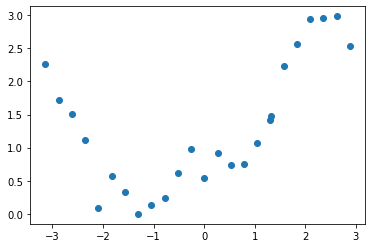

In [38]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf_at_1a, 1, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13])

### Generate torsion scans for the vanilla htf with flattened torsions (and sidechains not mapped): THR->ALA

In [8]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/32/"
with open(os.path.join(outdir, "32_vacuum.pickle" ), "rb") as f:
    htf_ta = pickle.load(f)
htf_ta_0t = copy.copy(htf_ta)
htf_ta_0a = copy.copy(htf_ta)
htf_ta_1a = copy.copy(htf_ta)
htf_ta_1t = copy.copy(htf_ta)

#### Look at hybrid topology to determine indices

In [9]:
for atom in htf_ta.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
THR2-CB 26
THR2-HB1 27
THR2-HB2 28
THR2-HB3 29
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [10]:
for atom in htf_ta._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [11]:
for atom in htf_ta._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (C) of chain 0 residue 1 (ALA)> 11
<Atom 12 (O) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


100%|██████████| 10000/10000 [00:01<00:00, 5924.98it/s]


3.0743732
228.5232312861079


INFO:root:Rotating by -6.021185302286687 radians
INFO:root:Rotating by 0.26200000000000356 radians


143.6509004980719


INFO:root:Rotating by 0.2619999999999969 radians


112.2236426387638


INFO:root:Rotating by 0.26199999999999735 radians


74.4535349499387


INFO:root:Rotating by 0.26199999999999735 radians


52.25268991807952


INFO:root:Rotating by 0.2620000000000009 radians


37.24448751805868


INFO:root:Rotating by 0.26200000000000156 radians


22.332008497190344


INFO:root:Rotating by 0.2620000000000047 radians


20.388936464752476


INFO:root:Rotating by 0.26199999999999846 radians


21.453207951605748


INFO:root:Rotating by 0.2620000000000027 radians


43.51108078330837


INFO:root:Rotating by 0.26200000000000234 radians


44.54869700582102


INFO:root:Rotating by 0.2620000000000036 radians


50.06603202938214


INFO:root:Rotating by 0.2620000000000002 radians


54.718285423986394


INFO:root:Rotating by 0.262 radians


42.962579211058475


INFO:root:Rotating by 0.26200000000000245 radians


45.169427278130584


INFO:root:Rotating by 0.2619999999999981 radians


36.0628675116086


INFO:root:Rotating by 0.26200000000000323 radians


27.749744429635903


INFO:root:Rotating by 0.26199999999999957 radians


33.272111606365705


INFO:root:Rotating by 0.2620000000000007 radians


32.18979344150808


INFO:root:Rotating by 0.26199999999999646 radians


37.409170467181255


INFO:root:Rotating by 0.26200000000000045 radians


43.58633796461304


INFO:root:Rotating by 0.2620000000000027 radians


43.203517049448436


INFO:root:Rotating by 0.2619999999999969 radians


45.8218335675798


INFO:root:Rotating by 0.2619999999999987 radians


35.5890782068752


INFO:root:Rotating by -6.0211853071795876 radians


41.03597137648734
raw d: {-2.9468120619403284: (172.97210720380687, 16.627685551373908), -2.6848120619403284: (119.95306486404372, 4.938815988514874), -2.4228120619403284: (88.6896481504911, 8.86199625895688), -2.1608120619403284: (59.472823384040105, 3.6138851918492114), -1.8988120619403284: (40.24752277770179, 2.3944520529776545), -1.6368120619403284: (23.734266059473992, 3.902744534753011), -1.3748120619403283: (23.858676405432437, 1.84562555322365), -1.1128120619403283: (22.266493067964053, 1.6236466710860251), -0.8508120619403283: (37.81338215502385, 6.363504524956488), -0.5888120619403283: (46.74449295723294, 1.2964977739885617), -0.3268120619403283: (49.629429559043736, 4.546499972737642), -0.06481206194032829: (47.85864271563238, 3.7132769994846266), 0.19718793805967172: (41.94687218488635, 0.5079754844357861), 0.45918793805967173: (38.00602415241982, 4.314023593132835), 0.7211879380596717: (32.842256026540326, 4.393179401861617), 0.9831879380596718: (34.44371395279001, 3.82224

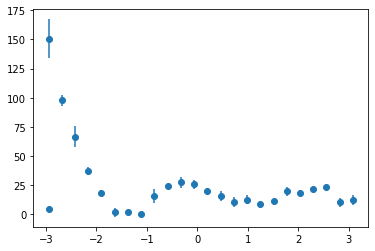

In [12]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(htf_ta_0t, 0, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19])

100%|██████████| 10000/10000 [00:01<00:00, 6114.71it/s]


0.4997126
29.201919528040897


INFO:root:Rotating by 0.2620000790851189 radians
INFO:root:Rotating by 0.2619999999999961 radians


30.160492890580787


INFO:root:Rotating by 0.2619999999999951 radians


6.677119748931806


INFO:root:Rotating by 0.2620000000000031 radians


27.869149601594007


INFO:root:Rotating by 0.26200000000000023 radians


25.457963901743955


INFO:root:Rotating by 0.26199999999999424 radians


29.66592640396482


INFO:root:Rotating by 0.26200000000000623 radians


30.079244267579632


INFO:root:Rotating by 0.2620000000000031 radians


13.507919710643261


INFO:root:Rotating by 0.26200000000000223 radians


33.33691565028987


INFO:root:Rotating by 0.26200000000000045 radians


22.468735523979834


INFO:root:Rotating by -6.021185307179591 radians


28.00191127739869


INFO:root:Rotating by 0.2620000000000018 radians


36.34835564310963


INFO:root:Rotating by 0.262 radians


24.065928212595185


INFO:root:Rotating by 0.26199999999999957 radians


36.348299946528414


INFO:root:Rotating by 0.262 radians


18.548544238369928


INFO:root:Rotating by 0.26200000000000734 radians


35.66358210324139


INFO:root:Rotating by 0.26200000000000223 radians


18.437015815210273


INFO:root:Rotating by 0.26200000000000045 radians


19.4931734686267


INFO:root:Rotating by 0.26200000000000134 radians


17.130035435129013


INFO:root:Rotating by 0.26199999999999857 radians


29.281124466610112


INFO:root:Rotating by 0.2619999999999951 radians


20.82730716728917


INFO:root:Rotating by 0.26200000000000045 radians


23.94684167901327


INFO:root:Rotating by 0.2619999999999957 radians


22.66683088527173


INFO:root:Rotating by 0.2620000000000027 radians


28.09464423284087


INFO:root:Rotating by 0.261999999999997 radians


29.167797357392313
raw d: {0.7617125864028931: (28.06467530073935, 1.6578628550626182), 1.023712586402893: (1.4293074133949268, 2.6275243699835706), 1.285712586402893: (25.64709689808622, 1.2893402763720252), 1.547712586402893: (26.095455897341935, 1.7834378778094677), 1.8097125864028931: (30.231141963684006, 4.06466388803499), 2.071712586402893: (32.82351024314565, 2.924447744008024), 2.333712586402893: (13.517853663851715, 5.136851297270581), 2.595712586402893: (30.364841826314336, 2.350223967547781), 2.857712586402893: (25.434828217063696, 3.070670631630963), 3.119712586402893: (28.337217885443966, 0.41227198736104015), -2.901472720776693: (27.571469217281685, 4.815314778022712), -2.639472720776693: (27.372390031921068, 1.8234948504652257), -2.377472720776693: (26.36073811107725, 4.994990137917917), -2.115472720776693: (26.812218909333776, 4.259456493315013), -1.853472720776693: (25.812502778816064, 5.064610329781332), -1.591472720776693: (24.080810801217183, 2.8242300706294245), -1

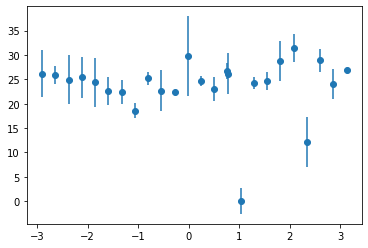

In [13]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(htf_ta_0a, 0, False, [6, 8, 26, 27], [6, 8, 10, 13], [28, 29])

100%|██████████| 10000/10000 [00:01<00:00, 5905.03it/s]
INFO:root:Rotating by 0.2620000790851189 radians


0.4997126
-61.61593857003877


INFO:root:Rotating by 0.2619999999999961 radians


-50.09505282326955


INFO:root:Rotating by 0.2619999999999951 radians


-62.70278495346218


INFO:root:Rotating by 0.2620000000000031 radians


-55.82734340128105


INFO:root:Rotating by 0.26200000000000023 radians


-58.840838343277824


INFO:root:Rotating by 0.26199999999999424 radians


-75.46705598357795


INFO:root:Rotating by 0.26200000000000623 radians


-49.90003731668313


INFO:root:Rotating by 0.2620000000000031 radians


-50.32892286348034


INFO:root:Rotating by 0.26200000000000223 radians


-44.50565427490771


INFO:root:Rotating by 0.26200000000000045 radians


-47.06653365606498


INFO:root:Rotating by -6.021185307179591 radians


-50.39504443936105


INFO:root:Rotating by 0.2620000000000018 radians


-49.8369774585201


INFO:root:Rotating by 0.262 radians


-52.35360007001132


INFO:root:Rotating by 0.26199999999999957 radians


-51.34362497983793


INFO:root:Rotating by 0.262 radians


-50.777050842996914


INFO:root:Rotating by 0.26200000000000734 radians


-57.99036691254626


INFO:root:Rotating by 0.26200000000000223 radians


-51.78148038802474


INFO:root:Rotating by 0.26200000000000045 radians


-43.61238762520589


INFO:root:Rotating by 0.26200000000000134 radians


-47.78549194789263


INFO:root:Rotating by 0.26199999999999857 radians


-64.50689927800859


INFO:root:Rotating by 0.2619999999999951 radians


-49.804589376329446


INFO:root:Rotating by 0.26200000000000045 radians


-65.12237365524315


INFO:root:Rotating by 0.2619999999999957 radians


-49.93979313834749


INFO:root:Rotating by 0.2620000000000027 radians


-55.62963513256059


INFO:root:Rotating by 0.261999999999997 radians


-43.66434906932548
raw d: {0.7617125864028931: (-55.461934997942514, 2.7333146393633574), 1.023712586402893: (-56.81738412795669, 4.142133515122015), 1.285712586402893: (-55.204357504180706, 2.849223822149979), 1.547712586402893: (-57.26748991241586, 1.6270892533194605), 1.8097125864028931: (-63.48255418110805, 5.999463626030146), 2.071712586402893: (-49.59414786367878, 4.509195548528732), 2.333712586402893: (-49.36756509632625, 3.6602349208095353), 2.595712586402893: (-47.03101806695582, 1.6259737310503797), 2.857712586402893: (-52.070746895858896, 3.2439417669663015), 3.119712586402893: (-54.37971032667477, 3.224336728966488), -2.901472720776693: (-53.04139465928093, 1.740067262473874), -2.639472720776693: (-50.064022580806245, 1.729725703643662), -2.377472720776693: (-49.611439042489955, 0.8663905226038294), -2.115472720776693: (-49.600514909383776, 0.6315876073484178), -1.853472720776693: (-54.106933238086405, 2.666205535148488), -1.591472720776693: (-49.53105171209899, 2.973605109

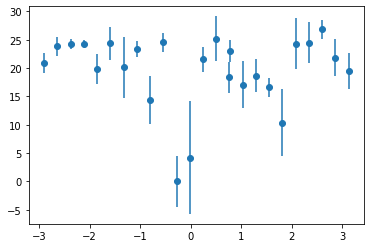

In [14]:
# THR->ALA -- ALA at lambda = 1
run_torsion_scan(htf_ta_1a, 1, False,  [6, 8, 26, 27], [6, 8, 10, 13], [28, 29])

100%|██████████| 10000/10000 [00:01<00:00, 5350.11it/s]
INFO:root:Rotating by -6.021185302286687 radians


3.0743732
-72.65724561555747


INFO:root:Rotating by 0.26200000000000356 radians


-79.53389831577587


INFO:root:Rotating by 0.2619999999999969 radians


-52.68915634302127


INFO:root:Rotating by 0.26199999999999735 radians


-44.390040816707014


INFO:root:Rotating by 0.26199999999999735 radians


-50.012057826617806


INFO:root:Rotating by 0.2620000000000009 radians


-48.36537174778857


INFO:root:Rotating by 0.26200000000000156 radians


-38.793046047482974


INFO:root:Rotating by 0.2620000000000047 radians


-30.18444274651265


INFO:root:Rotating by 0.26199999999999846 radians


-33.35103847822321


INFO:root:Rotating by 0.2620000000000027 radians


-15.80732970446597


INFO:root:Rotating by 0.26200000000000234 radians


-19.170990230149553


INFO:root:Rotating by 0.2620000000000036 radians


-23.99753526215475


INFO:root:Rotating by 0.2620000000000002 radians


-18.08683220720054


INFO:root:Rotating by 0.262 radians


-18.890387955958825


INFO:root:Rotating by 0.26200000000000245 radians


-29.567450818159475


INFO:root:Rotating by 0.2619999999999981 radians


-33.39810949157068


INFO:root:Rotating by 0.26200000000000323 radians


-35.56839612185565


INFO:root:Rotating by 0.26199999999999957 radians


-37.16328602176375


INFO:root:Rotating by 0.2620000000000007 radians


-50.1165674341595


INFO:root:Rotating by 0.26199999999999646 radians


-43.8596027277465


INFO:root:Rotating by 0.26200000000000045 radians


-44.441685489875304


INFO:root:Rotating by 0.2620000000000027 radians


-53.16406357324827


INFO:root:Rotating by 0.2619999999999969 radians


-39.901312408007755


INFO:root:Rotating by 0.2619999999999987 radians


-36.910159669611055


INFO:root:Rotating by -6.0211853071795876 radians


-45.17016176429174
raw d: {-2.9468120619403284: (-78.78069493529544, 0.8164371393500804), -2.6848120619403284: (-68.34669119856025, 7.84595226041584), -2.4228120619403284: (-42.448870313895206, 1.9895091515403482), -2.1608120619403284: (-45.716344211464445, 3.3477829780778023), -1.8988120619403284: (-40.773715571710134, 4.060861104540845), -1.6368120619403284: (-40.43408292154252, 2.3531896586489394), -1.3748120619403283: (-37.479078016578065, 3.935113842479397), -1.1128120619403283: (-33.08896445850914, 0.6240566793309319), -0.8508120619403283: (-21.872424980670317, 3.058072337204705), -0.5888120619403283: (-20.403084077465426, 2.1979570838304805), -0.3268120619403283: (-23.94530091243266, 0.6809074083473762), -0.06481206194032829: (-20.41152761904044, 1.2219674164586152), 0.19718793805967172: (-18.03609464560884, 0.4278255682808084), 0.45918793805967173: (-27.360709295218467, 1.6971956677633029), 0.7211879380596717: (-27.199498361276184, 4.0725752093851995), 0.9831879380596718: (-36.

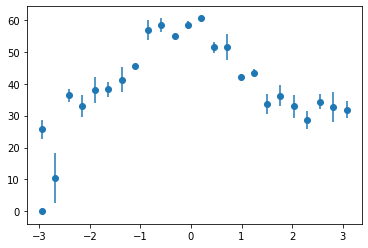

In [15]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(htf_ta_1t, 1, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19])

### Generate torsion scans for vanilla htfs with flattened torsions and 1,4s (and sidechains not mapped): ALA->THR 

In [12]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/31/"
with open(os.path.join(outdir, "31_vacuum.pickle" ), "rb") as f:
    htf_at = pickle.load(f)

In [13]:
old_system = htf_at._topology_proposal.old_system
new_system = htf_at._topology_proposal.new_system

In [14]:
htf_at._atom_classes['unique_new_atoms']

{22, 23, 24, 25, 26, 27, 28, 29}

In [15]:
htf_at._atom_classes['unique_old_atoms']

{10, 11, 12, 13}

In [16]:
for i in range(old_system.getNumForces()):
    print(i, old_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2ae5be0bde10> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2ae5be0bde10> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2ae5be0bde10> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ae5be0bde10> >


In [17]:
for i in range(new_system.getNumForces()):
    print(i, new_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2ae5650903c0> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2ae5650903c0> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2ae5650903c0> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ae5650903c0> >


In [18]:
nb_force = old_system.getForce(3)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in [10, 11, 12, 13] or p2 in [10, 11, 12, 13]:
        if abs(p1-p2) == 3:
            nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [19]:
nb_force = new_system.getForce(3)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in [10, 13, 14, 15, 16, 17, 18, 19] or p2 in [10, 13, 14, 15, 16, 17, 18, 19]:
        if abs(p1-p2) == 3: 
            nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [20]:
# Check that the 1,4s involving unique old are off
for i in range(old_system.getForce(3).getNumExceptions()):
    print(old_system.getForce(3).getExceptionParameters(i))

[0, 1, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[2, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 4, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 4, Quantity(value=0.0, unit=elementary charge**2), Quantit

In [21]:
# Check that the 1,4s involving unique new are off
for i in range(new_system.getForce(3).getNumExceptions()):
    print(new_system.getForce(3).getExceptionParameters(i))

[0, 1, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[2, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 4, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 4, Quantity(value=0.0, unit=elementary charge**2), Quantit

In [22]:
for atom in htf_at.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [23]:
for atom in htf_at._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [24]:
for atom in htf_at._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [25]:
# Build new htf
from perses.tests.test_topology_proposal import generate_atp
htf_at._topology_proposal._old_system = old_system
htf_at._topology_proposal._new_system = new_system

from perses.annihilation.relative import HybridTopologyFactory
htf = HybridTopologyFactory(topology_proposal=htf_at._topology_proposal,
                     current_positions=htf_at.old_positions(htf_at.hybrid_positions),
                     new_positions=htf_at.new_positions(htf_at.hybrid_positions),
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=False,
                     omitted_terms=None,
                     flatten_torsions=True)

RDKit WARNING: [20:26:04] Enabling RDKit 2019.09.3 jupyter extensions
INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating ol

In [26]:
for i in range(htf.hybrid_system.getNumForces()):
    print(i, htf.hybrid_system.getForce(i))

0 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ae5c357f090> >
1 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2ae5c357f090> >
2 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ae5c357f090> >
3 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2ae5c357f090> >
4 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ae5c357f090> >
5 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2ae5c357f090> >
6 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ae5c357f090> >
7 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2ae5c357f090> >
8 <simtk.ope

In [27]:
# Check that the 1,4s involving unique new are off
for i in range(htf.hybrid_system.getForce(6).getNumExceptions()):
    print(htf.hybrid_system.getForce(6).getExceptionParameters(i))

[10, 22, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 23, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 24, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 25, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 26, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 27, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 28, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 29, Quantity(value=0.0, unit=elementary cha

In [28]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB1) of chain 0 residue 1 (ALA)>
<Atom 12 (HB2) of chain 0 residue 1 (ALA)>
<Atom 13 (HB3) of chain 0 residue 1 (ALA)>
<Atom 14 (C) of chain 0 residue 1 (ALA)>
<Atom 15 (O) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [24]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


100%|██████████| 10000/10000 [00:01<00:00, 5982.34it/s]


1.0471988
10.066165007672403


INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999929 radians


13.615615490399003


INFO:root:Rotating by 0.26200000000000334 radians


7.912438805931591


INFO:root:Rotating by 0.26199999999999823 radians


13.771066609354532


INFO:root:Rotating by 0.2620000000000058 radians


23.385624146295818


INFO:root:Rotating by 0.2620000000000031 radians


9.7377366727603


INFO:root:Rotating by 0.26199999999999957 radians


17.71244577215738


INFO:root:Rotating by -6.0211853071795876 radians


11.51981378881569


INFO:root:Rotating by 0.26199999999994183 radians


6.985381218318895


INFO:root:Rotating by 0.26200000000005597 radians


4.727666862502012


INFO:root:Rotating by 0.2619999999999991 radians


16.075414790953733


INFO:root:Rotating by 0.2620000000000009 radians


7.7922891112820585


INFO:root:Rotating by 0.26200000000000356 radians


16.057350170593814


INFO:root:Rotating by 0.2620000000000027 radians


18.953073298788485


INFO:root:Rotating by 0.26199999999999823 radians


14.952645004152611


INFO:root:Rotating by 0.2620000000000011 radians


16.671624274393736


INFO:root:Rotating by 0.2620000000000009 radians


8.721521017455158


INFO:root:Rotating by 0.26200000000000034 radians


8.643374679701608


INFO:root:Rotating by 0.262000000000004 radians


5.952131621081102


INFO:root:Rotating by 0.26199999999999807 radians


24.21514251216303


INFO:root:Rotating by 0.26200000000000323 radians


9.111589066973574


INFO:root:Rotating by 0.2620000000000027 radians


12.884894885627126


INFO:root:Rotating by 0.2620000000000027 radians


17.00210337044465


INFO:root:Rotating by 0.26199999999999946 radians


7.8151156331287615


INFO:root:Rotating by 0.2619999999999978 radians


16.983341655484328
raw d: {1.30919877243042: (8.945153289213927, 3.4286630653944385), 1.57119877243042: (6.036913976198833, 3.9625691413284745), 1.83319877243042: (19.99040143307181, 3.2454273576183956), 2.09519877243042: (15.662147816334816, 3.9306269116043695), 2.35719877243042: (15.312930405714559, 3.1920129215295248), 2.61919877243042: (18.11039042278172, 0.32198239417342167), 2.88119877243042: (10.830060317445081, 4.6826523669809035), -3.1399865347491662: (8.490703569927124, 3.2582354392341712), -2.877986534749166: (4.606003479314729, 2.818949247881345), -2.615986534749166: (11.794918908254099, 4.6839588971917046), -2.353986534749166: (8.981285334402111, 2.0025502515363236), -2.091986534749166: (11.71980189711161, 2.1746961603678274), -1.8299865347491662: (12.498141503272732, 3.505279060266715), -1.5679865347491662: (12.737707916903787, 2.47580131172227), -1.3059865347491662: (18.881212118717333, 2.3361747871163527), -1.0439865347491661: (11.309146077695553, 2.423612395162832), -0

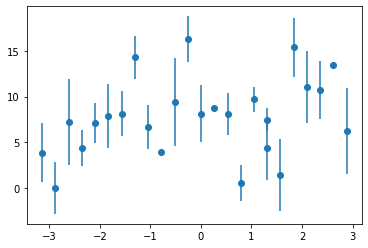

In [33]:
# # ALA->THR -- ALA at lambda = 0
# run_torsion_scan(htf, 0, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13])

  6%|▌         | 593/10000 [00:00<00:01, 5919.74it/s]

-97.64257922839127


100%|██████████| 10000/10000 [00:01<00:00, 6327.89it/s]


2.7912235
-32.98107196661712


INFO:root:Rotating by 0.2620000119779138 radians
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000

-34.47780810476256
-33.698745365228724
-31.386089242143612
-28.34082084309793
-25.035129516696863
-21.667254755494834
-18.277033742610605
-14.810563374316732
-11.136039686753993
-7.073486839723678
-2.6144588351356672
1.496085755958595
3.398778742242107
1.3918192642387979
-4.0783422004472305
-10.903364953979294
-17.3253319964848
-22.439639645126146
-25.624035649584492
-26.564126770227574
-26.20328862852245
-26.875988297005893
-29.74525599326277
-33.02937167354986
raw d: {3.0532235260009766: (-34.47780810476256, nan), -2.9679617811786096: (-33.698745365228724, nan), -2.7059617811786096: (-31.386089242143612, nan), -2.4439617811786096: (-28.34082084309793, nan), -2.1819617811786096: (-25.035129516696863, nan), -1.9199617811786096: (-21.667254755494834, nan), -1.6579617811786096: (-18.277033742610605, nan), -1.3959617811786096: (-14.810563374316732, nan), -1.1339617811786096: (-11.136039686753993, nan), -0.8719617811786096: (-7.073486839723678, nan), -0.6099617811786096: (-2.61445883513566

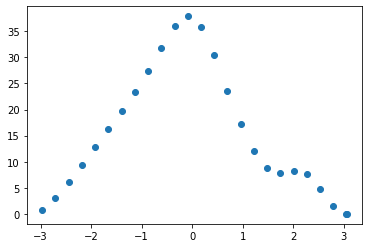

In [29]:
# ALA->THR -- THR at lambda = 0
torsion_scans.append(run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]))

100%|██████████| 10000/10000 [00:01<00:00, 6086.91it/s]
INFO:root:Rotating by 0.2620000119779138 radians


2.7912235
85.64782146149645


INFO:root:Rotating by -6.021185307179585 radians


83.16144775186059


INFO:root:Rotating by 0.262 radians


89.20390938552033


INFO:root:Rotating by 0.26200000000000134 radians


84.90758747603832


INFO:root:Rotating by 0.2620000000000027 radians


84.08865424861192


INFO:root:Rotating by 0.26199999999999557 radians


87.78186177317455


INFO:root:Rotating by 0.26199999999999934 radians


98.93534843795136


INFO:root:Rotating by 0.262 radians


100.90162965739411


INFO:root:Rotating by 0.2619999999999987 radians


107.97530021459214


INFO:root:Rotating by 0.26200000000000045 radians


90.78179042612776


INFO:root:Rotating by 0.26199999999999724 radians


83.1088363209761


INFO:root:Rotating by 0.2619999999999971 radians


74.22247310028112


INFO:root:Rotating by 0.26200000000000045 radians


78.83367281250355


INFO:root:Rotating by 0.26200000000000045 radians


72.01355019329107


INFO:root:Rotating by 0.2619999999999995 radians


71.61872717881447


INFO:root:Rotating by 0.2619999999999996 radians


87.43315877513015


INFO:root:Rotating by 0.26200000000000145 radians


65.1332185168607


INFO:root:Rotating by 0.2619999999999987 radians


74.93809371284809


INFO:root:Rotating by 0.2620000000000011 radians


82.1474276159332


INFO:root:Rotating by 0.26200000000000045 radians


84.0111524129918


INFO:root:Rotating by 0.2619999999999978 radians


85.42583776117176


INFO:root:Rotating by 0.26199999999999735 radians


93.30668847416489


INFO:root:Rotating by 0.2619999999999951 radians


78.24733179298659


INFO:root:Rotating by 0.26199999999999823 radians


227.97209517660295


INFO:root:Rotating by 0.2619999999999987 radians


193.93601076763312
raw d: {3.0532235260009766: (89.35478587833971, 3.1071308550792667), -2.9679617811786096: (83.52887818614113, 3.3383567588442586), -2.7059617811786096: (84.82532620974683, 1.5984356421672359), -2.4439617811786096: (93.3708169598846, 6.322036746586779), -2.1819617811786096: (90.91854462212488, 2.6482088238690795), -1.9199617811786096: (96.18316813683367, 5.843626988298512), -1.6579617811786096: (99.1270514817961, 2.421568313117374), -1.3959617811786096: (101.75053006896464, 5.442235622151454), -1.1339617811786096: (94.38912233902579, 2.8595290679469336), -0.8719617811786096: (85.89945172829658, 1.935412374650737), -0.6099617811786096: (77.52342711154253, 1.888692551114203), -0.34796178117860954: (71.771639119684, 3.587393080493482), -0.08596178117860953: (74.16570532687547, 1.2732451417497188), 0.17603821882139048: (72.46081633591581, 2.3971921639728158), 0.4380382188213905: (76.4657155754965, 5.672628313911505), 0.7000382188213905: (72.07998675555493, 3.4776716750284

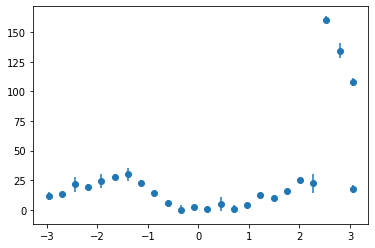

In [35]:
# # ALA->THR -- THR at lambda = 1
# run_torsion_scan(htf_at_1t, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29])

39.27942448794531


100%|██████████| 10000/10000 [00:01<00:00, 6271.43it/s]
INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians


1.0471988
18.745951789111526
-21.57776433641308


INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians


-21.511072241198775
-21.103967565188015


INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians


-21.174028134215632
-20.08423346019533


INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians


-20.429600939088708
-20.762408730736524


INFO:root:Rotating by 0.2620000000000111 radians
INFO:root:Rotating by 0.2619999999999889 radians


-20.298728882208056
-19.507384297364155


INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians


-20.74332261928962
-19.954091756554636


INFO:root:Rotating by 0.262 radians


-20.409815611130682


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians


-20.65742779968003
-20.49699552017952


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians


-21.302489069682288
-21.414307603535267


INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians


-21.11403761123688
-20.633940478754926


INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000323 radians


-20.92714057808625
-20.347164097309054


INFO:root:Rotating by 0.2619999999999972 radians
INFO:root:Rotating by 0.26199999999999946 radians


-20.928568174884617
-21.259533155753807


INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000045 radians


-21.318834822909594
-21.83468764979398
raw d: {1.30919877243042: (-21.57776433641308, nan), 1.57119877243042: (-21.511072241198775, nan), 1.83319877243042: (-21.103967565188015, nan), 2.09519877243042: (-21.174028134215632, nan), 2.35719877243042: (-20.08423346019533, nan), 2.61919877243042: (-20.429600939088708, nan), 2.88119877243042: (-20.762408730736524, nan), -3.1399865347491662: (-20.298728882208056, nan), -2.877986534749166: (-19.507384297364155, nan), -2.615986534749166: (-20.74332261928962, nan), -2.353986534749166: (-19.954091756554636, nan), -2.091986534749166: (-20.409815611130682, nan), -1.8299865347491662: (-20.65742779968003, nan), -1.5679865347491662: (-20.49699552017952, nan), -1.3059865347491662: (-21.302489069682288, nan), -1.0439865347491661: (-21.414307603535267, nan), -0.7819865347491661: (-21.11403761123688, nan), -0.5199865347491661: (-20.633940478754926, nan), -0.2579865347491661: (-20.92714057808625, nan), 0.004013465250833903: (-20.347164097309054, nan), 0.26

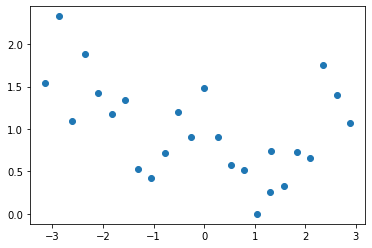

In [32]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf, 1, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13])

### Generate torsion scans for vanilla htfs with flattened 1,4s only (and sidechains not mapped): ALA->THR 

In [63]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/5/"
with open(os.path.join(outdir, "5_vacuum.pickle" ), "rb") as f:
    htf_at = pickle.load(f)

In [64]:
old_system = htf_at._topology_proposal.old_system
new_system = htf_at._topology_proposal.new_system

In [65]:
htf_at._atom_classes['unique_new_atoms'] # These are not right

{22, 23, 24, 25, 26, 27, 28}

In [66]:
htf_at._atom_classes['unique_old_atoms']

{11, 12, 15}

In [49]:
for i in range(old_system.getNumForces()):
    print(i, old_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b22ee2aa180> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b22ee2aa180> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b22ee2aa180> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b22ee2aa180> >


In [68]:
nb_force = old_system.getForce(3)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in [11, 12, 15] or p2 in [11, 12, 15]:
        nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [69]:
nb_force = new_system.getForce(3)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in [13, 14, 15, 16, 17, 18, 19] or p2 in [13, 14, 15, 16, 17, 18, 19]:
        nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [33]:
# Check that the 1,4s involving unique old are off
for i in range(old_system.getForce(3).getNumExceptions()):
    print(old_system.getForce(3).getExceptionParameters(i))

[0, 1, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[2, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 4, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 4, Quantity(value=0.0, unit=elementary charge**2), Quantit

In [34]:
# Check that the 1,4s involving unique new are off
for i in range(new_system.getForce(3).getNumExceptions()):
    print(new_system.getForce(3).getExceptionParameters(i))

[0, 1, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 2, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[2, 3, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[0, 4, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[1, 4, Quantity(value=0.0, unit=elementary charge**2), Quantit

In [54]:
for atom in htf_at.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB2 11
ALA2-HB3 12
ALA2-C 13
ALA2-O 14
ALA2-HB1 15
ALA2-HB 22
ALA2-CG2 23
ALA2-HG21 24
ALA2-HG22 25
ALA2-HG23 26
ALA2-OG1 27
ALA2-HG1 28
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [55]:
for atom in htf_at._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB2) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB3) of chain 0 residue 1 (ALA)> 12
<Atom 13 (C) of chain 0 residue 1 (ALA)> 13
<Atom 14 (O) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB1) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [56]:
for atom in htf_at._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [27]:
# Build new htf
from perses.tests.test_topology_proposal import generate_atp
htf_at._topology_proposal._old_system = old_system
htf_at._topology_proposal._new_system = new_system

from perses.annihilation.relative import HybridTopologyFactory
htf = HybridTopologyFactory(topology_proposal=htf_at._topology_proposal,
                     current_positions=htf_at.old_positions(htf_at.hybrid_positions),
                     new_positions=htf_at.new_positions(htf_at.hybrid_positions),
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=False,
                     omitted_terms=None,
                     flatten_torsions=False)

INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system except

In [39]:
for i in range(htf.hybrid_system.getNumForces()):
    print(i, htf.hybrid_system.getForce(i))

0 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b6ac5ce3660> >
1 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b6ac2069420> >
2 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b6ac2069420> >
3 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b6ac2069420> >
4 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b6ac2069420> >
5 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b6ac2069420> >
6 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b6ac2069420> >
7 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b6ac2069420> >
8 <simtk.ope

In [40]:
# Check that the 1,4s involving unique new are off
for i in range(htf.hybrid_system.getForce(6).getNumExceptions()):
    print(htf.hybrid_system.getForce(6).getExceptionParameters(i))

[10, 22, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 23, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 24, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 25, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 26, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 27, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 28, Quantity(value=0.0, unit=elementary charge**2), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[10, 29, Quantity(value=0.0, unit=elementary cha

In [71]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB2) of chain 0 residue 1 (ALA)>
<Atom 12 (HB3) of chain 0 residue 1 (ALA)>
<Atom 13 (C) of chain 0 residue 1 (ALA)>
<Atom 14 (O) of chain 0 residue 1 (ALA)>
<Atom 15 (HB1) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [72]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [73]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB2 11
ALA2-HB3 12
ALA2-C 13
ALA2-O 14
ALA2-HB1 15
ALA2-HB 22
ALA2-CG2 23
ALA2-HG21 24
ALA2-HG22 25
ALA2-HG23 26
ALA2-OG1 27
ALA2-HG1 28
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


100%|██████████| 10000/10000 [00:01<00:00, 5982.34it/s]


1.0471988
10.066165007672403


INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999929 radians


13.615615490399003


INFO:root:Rotating by 0.26200000000000334 radians


7.912438805931591


INFO:root:Rotating by 0.26199999999999823 radians


13.771066609354532


INFO:root:Rotating by 0.2620000000000058 radians


23.385624146295818


INFO:root:Rotating by 0.2620000000000031 radians


9.7377366727603


INFO:root:Rotating by 0.26199999999999957 radians


17.71244577215738


INFO:root:Rotating by -6.0211853071795876 radians


11.51981378881569


INFO:root:Rotating by 0.26199999999994183 radians


6.985381218318895


INFO:root:Rotating by 0.26200000000005597 radians


4.727666862502012


INFO:root:Rotating by 0.2619999999999991 radians


16.075414790953733


INFO:root:Rotating by 0.2620000000000009 radians


7.7922891112820585


INFO:root:Rotating by 0.26200000000000356 radians


16.057350170593814


INFO:root:Rotating by 0.2620000000000027 radians


18.953073298788485


INFO:root:Rotating by 0.26199999999999823 radians


14.952645004152611


INFO:root:Rotating by 0.2620000000000011 radians


16.671624274393736


INFO:root:Rotating by 0.2620000000000009 radians


8.721521017455158


INFO:root:Rotating by 0.26200000000000034 radians


8.643374679701608


INFO:root:Rotating by 0.262000000000004 radians


5.952131621081102


INFO:root:Rotating by 0.26199999999999807 radians


24.21514251216303


INFO:root:Rotating by 0.26200000000000323 radians


9.111589066973574


INFO:root:Rotating by 0.2620000000000027 radians


12.884894885627126


INFO:root:Rotating by 0.2620000000000027 radians


17.00210337044465


INFO:root:Rotating by 0.26199999999999946 radians


7.8151156331287615


INFO:root:Rotating by 0.2619999999999978 radians


16.983341655484328
raw d: {1.30919877243042: (8.945153289213927, 3.4286630653944385), 1.57119877243042: (6.036913976198833, 3.9625691413284745), 1.83319877243042: (19.99040143307181, 3.2454273576183956), 2.09519877243042: (15.662147816334816, 3.9306269116043695), 2.35719877243042: (15.312930405714559, 3.1920129215295248), 2.61919877243042: (18.11039042278172, 0.32198239417342167), 2.88119877243042: (10.830060317445081, 4.6826523669809035), -3.1399865347491662: (8.490703569927124, 3.2582354392341712), -2.877986534749166: (4.606003479314729, 2.818949247881345), -2.615986534749166: (11.794918908254099, 4.6839588971917046), -2.353986534749166: (8.981285334402111, 2.0025502515363236), -2.091986534749166: (11.71980189711161, 2.1746961603678274), -1.8299865347491662: (12.498141503272732, 3.505279060266715), -1.5679865347491662: (12.737707916903787, 2.47580131172227), -1.3059865347491662: (18.881212118717333, 2.3361747871163527), -1.0439865347491661: (11.309146077695553, 2.423612395162832), -0

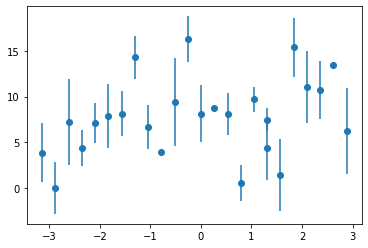

In [33]:
# # ALA->THR -- ALA at lambda = 0
# run_torsion_scan(htf, 0, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13])

 19%|█▉        | 1879/10000 [00:00<00:00, 18789.61it/s]

-11.246748659500383


100%|██████████| 10000/10000 [00:00<00:00, 20264.76it/s]
INFO:root:Rotating by 0.8038853223102362 radians
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2620000000000002 radians
INFO:root:Rotating by 0.2619999999999994 radians
INFO:root:Rotating by 0.2620000000000006 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:

-1.1785822
2.0419697292486116
6.5622770651416635
8.267793139769138
8.505248574822293
7.15601242317006
4.869982927958081
2.7227587019948087
1.6650564160260701
2.03042963376225
3.355425638635543
4.633433281433738
4.900004176077893
3.8291581573178877
1.9693412075538574
0.43296619179491286
0.2009874287124472
1.481616712563966
3.554393200249302
5.219921296899349
5.564828954048804
4.537181794574931
2.9623796840289636
2.0089487641802086
2.4653583489444566
4.278357673991351
raw d: {-0.9165821914672851: (6.5622770651416635, nan), -0.6545821914672851: (8.267793139769138, nan), -0.3925821914672851: (8.505248574822293, nan), -0.1305821914672851: (7.15601242317006, nan), 0.1314178085327149: (4.869982927958081, nan), 0.3934178085327149: (2.7227587019948087, nan), 0.6554178085327149: (1.6650564160260701, nan), 0.9174178085327149: (2.03042963376225, nan), 1.179417808532715: (3.355425638635543, nan), 1.441417808532715: (4.633433281433738, nan), 1.703417808532715: (4.900004176077893, nan), 1.96541780853

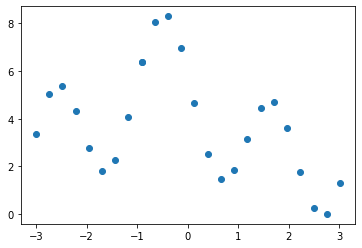

In [76]:
# ALA->THR -- THR at lambda = 0
run_torsion_scan(htf, 0, False, [6, 8, 10, 28], [6, 8, 10, 18], [22, 23, 24, 25, 26, 27, 28])

100%|██████████| 10000/10000 [00:01<00:00, 6086.91it/s]
INFO:root:Rotating by 0.2620000119779138 radians


2.7912235
85.64782146149645


INFO:root:Rotating by -6.021185307179585 radians


83.16144775186059


INFO:root:Rotating by 0.262 radians


89.20390938552033


INFO:root:Rotating by 0.26200000000000134 radians


84.90758747603832


INFO:root:Rotating by 0.2620000000000027 radians


84.08865424861192


INFO:root:Rotating by 0.26199999999999557 radians


87.78186177317455


INFO:root:Rotating by 0.26199999999999934 radians


98.93534843795136


INFO:root:Rotating by 0.262 radians


100.90162965739411


INFO:root:Rotating by 0.2619999999999987 radians


107.97530021459214


INFO:root:Rotating by 0.26200000000000045 radians


90.78179042612776


INFO:root:Rotating by 0.26199999999999724 radians


83.1088363209761


INFO:root:Rotating by 0.2619999999999971 radians


74.22247310028112


INFO:root:Rotating by 0.26200000000000045 radians


78.83367281250355


INFO:root:Rotating by 0.26200000000000045 radians


72.01355019329107


INFO:root:Rotating by 0.2619999999999995 radians


71.61872717881447


INFO:root:Rotating by 0.2619999999999996 radians


87.43315877513015


INFO:root:Rotating by 0.26200000000000145 radians


65.1332185168607


INFO:root:Rotating by 0.2619999999999987 radians


74.93809371284809


INFO:root:Rotating by 0.2620000000000011 radians


82.1474276159332


INFO:root:Rotating by 0.26200000000000045 radians


84.0111524129918


INFO:root:Rotating by 0.2619999999999978 radians


85.42583776117176


INFO:root:Rotating by 0.26199999999999735 radians


93.30668847416489


INFO:root:Rotating by 0.2619999999999951 radians


78.24733179298659


INFO:root:Rotating by 0.26199999999999823 radians


227.97209517660295


INFO:root:Rotating by 0.2619999999999987 radians


193.93601076763312
raw d: {3.0532235260009766: (89.35478587833971, 3.1071308550792667), -2.9679617811786096: (83.52887818614113, 3.3383567588442586), -2.7059617811786096: (84.82532620974683, 1.5984356421672359), -2.4439617811786096: (93.3708169598846, 6.322036746586779), -2.1819617811786096: (90.91854462212488, 2.6482088238690795), -1.9199617811786096: (96.18316813683367, 5.843626988298512), -1.6579617811786096: (99.1270514817961, 2.421568313117374), -1.3959617811786096: (101.75053006896464, 5.442235622151454), -1.1339617811786096: (94.38912233902579, 2.8595290679469336), -0.8719617811786096: (85.89945172829658, 1.935412374650737), -0.6099617811786096: (77.52342711154253, 1.888692551114203), -0.34796178117860954: (71.771639119684, 3.587393080493482), -0.08596178117860953: (74.16570532687547, 1.2732451417497188), 0.17603821882139048: (72.46081633591581, 2.3971921639728158), 0.4380382188213905: (76.4657155754965, 5.672628313911505), 0.7000382188213905: (72.07998675555493, 3.4776716750284

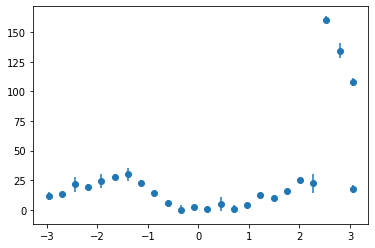

In [35]:
# # ALA->THR -- THR at lambda = 1
# run_torsion_scan(htf_at_1t, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29])

 21%|██        | 2055/10000 [00:00<00:00, 20547.47it/s]

245.64500577435126


100%|██████████| 10000/10000 [00:00<00:00, 21840.79it/s]


3.1412313
39.273009778113824


INFO:root:Rotating by -6.021185213713272 radians
INFO:root:Rotating by 0.26199999999967094 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999876 radians
INFO:root:Rotating by 0.2620000000000118 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rota

242.70982116584003
763.1656765826866
1561.4301753732311
2660.3647156966067
4028.3108888064507
5598.907134735638
7271.445999343406
8805.776343684078
10034.075887276236
10974.816320313488
11554.493740195769
11914.673656659168
13434.793336111492
24409.991463071026
59904.923666146904
65761.75970526818
25278.76604167414
7557.247555910727
3475.7664536456114
1906.0131918209029
1000.9517504299105
477.0718843632678
161.6732893976444
39.76367584702231
raw d: {-2.879954008732931: (242.70982116584003, nan), -2.617954008732931: (763.1656765826866, nan), -2.355954008732931: (1561.4301753732311, nan), -2.093954008732931: (2660.3647156966067, nan), -1.831954008732931: (4028.3108888064507, nan), -1.569954008732931: (5598.907134735638, nan), -1.3079540087329309: (7271.445999343406, nan), -1.0459540087329309: (8805.776343684078, nan), -0.7839540087329309: (10034.075887276236, nan), -0.5219540087329309: (10974.816320313488, nan), -0.25995400873293084: (11554.493740195769, nan), 0.0020459912670691693: (119

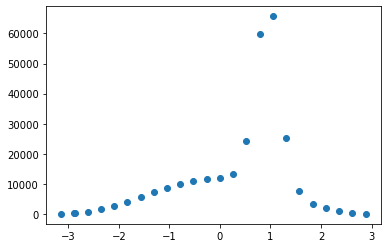

In [77]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf, 1, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13])

### Generate torsion scans for the vanilla htf with flattened torsions, 1,4s (and sidechains not mapped): THR->ALA

In [768]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/32/"
with open(os.path.join(outdir, "32_vacuum.pickle" ), "rb") as f:
    htf_ta = pickle.load(f)

In [769]:
htf_ta_0t = copy.copy(htf_ta)
htf_ta_0a = copy.copy(htf_ta)
htf_ta_1a = copy.copy(htf_ta)
htf_ta_1t = copy.copy(htf_ta)

In [770]:
htf_ta._atom_classes['unique_new_atoms']

{26, 27, 28, 29}

In [771]:
unique_new = [26, 27, 28, 29]

In [772]:
htf_ta._atom_classes['unique_old_atoms']

{10, 13, 14, 15, 16, 17, 18, 19}

In [773]:
unique_old = [10, 13, 14, 15, 16, 17] 

In [774]:
for i in range(htf_ta.hybrid_system.getNumForces()):
    print(i, htf_ta.hybrid_system.getForce(i))

0 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b140584ad80> >
1 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b140584ad80> >
2 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b140584ad80> >
3 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b140584ad80> >
4 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b140584ad80> >
5 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b140584ad80> >
6 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b140584ad80> >
7 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b140584ad80> >
8 <simtk.ope

In [775]:
nb_force = htf_ta_0t.hybrid_system.getForce(6)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in htf_ta._atom_classes['unique_new_atoms'] or p2 in htf_ta._atom_classes['unique_new_atoms']:
        nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [776]:
nb_force = htf_ta_0a.hybrid_system.getForce(6)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in htf_ta._atom_classes['unique_new_atoms'] or p2 in htf_ta._atom_classes['unique_new_atoms']:
        nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [777]:
# Check that the 1,4s involving unique new are off
for i in range(htf_ta_0.hybrid_system.getForce(6).getNumExceptions()):
    print(htf_ta_0.hybrid_system.getForce(6).getExceptionParameters(i))

NameError: name 'htf_ta_0' is not defined

In [778]:
nb_force = htf_ta_1a.hybrid_system.getForce(6)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in htf_ta._atom_classes['unique_old_atoms'] or p2 in htf_ta._atom_classes['unique_old_atoms']:
        nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [779]:
nb_force = htf_ta_1t.hybrid_system.getForce(6)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    if p1 in htf_ta._atom_classes['unique_old_atoms'] or p2 in htf_ta._atom_classes['unique_old_atoms']:
        nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

#### Look at hybrid topology to determine indices

In [ ]:
for atom in htf_ta.hybrid_topology.atoms:
    print(atom, atom.index)

In [ ]:
for atom in htf_ta._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

In [ ]:
for atom in htf_ta._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

In [ ]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(htf_ta_0, 0, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19])

In [ ]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(htf_ta_0, 0, False, [6, 8, 26, 27], [6, 8, 10, 11], [28, 29])

In [ ]:
# THR->ALA -- ALA at lambda = 1
run_torsion_scan(htf_ta_1, 1, False,  [6, 8, 26, 27], [6, 8, 10, 11], [28, 29])

In [ ]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(htf_ta_1, 1, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19])

###  Generate torsion scans for vanilla htf with 4 flattened exceptions and all torsions (sidechains not mapped): ALA->THR

In [18]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/31/"
with open(os.path.join(outdir, "31_vacuum.pickle" ), "rb") as f:
    htf_at = pickle.load(f)

In [19]:
old_system = htf_at._topology_proposal.old_system
new_system = htf_at._topology_proposal.new_system

In [20]:
for i in range(htf_at._topology_proposal.new_system.getNumForces()):
    print(i, htf_at._topology_proposal.new_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b317e08a3f0> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b317e08a3f0> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b31f3f6ddb0> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b317e08a3f0> >


In [21]:
for atom in htf_at.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [56]:
# # Flatten all 1,4s
# nb_force = old_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [57]:
# Flatten all 1,4s
# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         if p1 == 11 or p2 == 11:
#             print(nb_force.getExceptionParameters(i))
#             nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         if p1 == 11 and p2 == 14:
#             print(nb_force.getExceptionParameters(i))
#             nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [58]:
# # Flatten more torsions (for all atoms)
# periodic_torsion = old_system.getForce(2)
# for i in range(periodic_torsion.getNumTorsions()):
#     p1, p2, p3, p4, periodicity, phase, k = periodic_torsion.getTorsionParameters(i)
#     periodic_torsion.setTorsionParameters(i, p1, p2, p3, p4, periodicity, phase, 0.*k)

In [59]:
# # Flatten more torsions (for all atoms)
# periodic_torsion = new_system.getForce(2)
# for i in range(periodic_torsion.getNumTorsions()):
#     p1, p2, p3, p4, periodicity, phase, k = periodic_torsion.getTorsionParameters(i)
#     periodic_torsion.setTorsionParameters(i, p1, p2, p3, p4, periodicity, phase, 0.*k)

In [60]:
# # Flatten sterics, electrostatics
# nb_force = old_system.getForce(3)
# for i in range(nb_force.getNumParticles()):
#     chargeProd, sigma, epsilon = nb_force.getParticleParameters(i)
#     nb_force.setParticleParameters(i, 0, sigma, 0)

# # Flatten all exceptions
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [22]:
# off = list(range(0, 8)) + list(range(16, 23)) # no energy barrier
# off = list(range(0, 8)) # Still has somewhat high energy barrier, multiple minima
# off = list(range(16, 23)) # Still has somewhat high energy barrier
# off = [1, 6, 16, 18] # no energy barrier
# off = [1, 6, 18] # no energy barrier
# off = [1, 18] # energy barrier
# off = [6, 18] # no energy barrier
# off = [6] # no energy barrier


# # Flatten sterics, electrostatics
# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumParticles()):
# #     print(i, nb_force.getParticleParameters(i))
#     if i in off:
#         print(i, nb_force.getParticleParameters(i))
#         chargeProd, sigma, epsilon = nb_force.getParticleParameters(i)
#         nb_force.setParticleParameters(i, 0, sigma, 0)



# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         if p1 == 11 and p2 == 14:
#             print(nb_force.getExceptionParameters(i))
#             nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)
    
# print()
# print()

# off_pairs = [(6, 14), (6, 18), (11, 18), (11,14)]

# # Flatten all exceptions
# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
# #     print(i, nb_force.getExceptionParameters(i))
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if (p1, p2) in off_pairs:
# #         if chargeProd.value_in_unit_system(unit.md_unit_system) != 0 or epsilon.value_in_unit_system(unit.md_unit_system) != 0:
#         print(i, nb_force.getExceptionParameters(i))
#         nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

        
# Flatten all exceptions
nb_force = new_system.getForce(3)
for i in range(nb_force.getNumExceptions()):
#     print(i, nb_force.getExceptionParameters(i))
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#         print(i, nb_force.getExceptionParameters(i))
    nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)


In [23]:
# Build new htf
from perses.tests.test_topology_proposal import generate_atp
htf_at._topology_proposal._old_system = old_system
htf_at._topology_proposal._new_system = new_system

from perses.annihilation.relative import HybridTopologyFactory
htf = HybridTopologyFactory(topology_proposal=htf_at._topology_proposal,
                     current_positions=htf_at.old_positions(htf_at.hybrid_positions),
                     new_positions=htf_at.new_positions(htf_at.hybrid_positions),
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=True, ## NOTE: when this is True, don't need to modify old and new systems
                     omitted_terms=None,
                     flatten_torsions=True)

INFO:rdkit:Enabling RDKit 2020.09.1 jupyter extensions


INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Flattening torsions of unique new/old at lambda = 0/1
INFO:relative:Flattening exceptions of unique new/old at lambda = 0/1
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)

In [63]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [64]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

  0%|          | 0/10000 [00:00<?, ?it/s]

-15.520783206626676


100%|██████████| 10000/10000 [00:01<00:00, 6012.07it/s]


2.7912235
16.26843135708939


INFO:root:Rotating by 0.2620000119779138 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating 

16.268442200666346
16.26845719938352
16.268451718998648
16.26845113163453
16.268444085692106
16.268450598129633
16.268453915091694
16.268453391807906
16.268441740856158
16.268455587994296
16.268450979624607
16.2684558256469
16.26845503782758
16.26844603237126
16.268456968638333
16.268461297350832
16.268454569756486
16.268448229211053
16.268443794506986
16.2684441769354
16.268456732105847
16.268456175078377
16.268445851518187
16.268447431637327


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


raw d: {3.0532235260009766: (16.268442200666346, nan), -2.9679617811786096: (16.26845719938352, nan), -2.7059617811786096: (16.268451718998648, nan), -2.4439617811786096: (16.26845113163453, nan), -2.1819617811786096: (16.268444085692106, nan), -1.9199617811786096: (16.268450598129633, nan), -1.6579617811786096: (16.268453915091694, nan), -1.3959617811786096: (16.268453391807906, nan), -1.1339617811786096: (16.268441740856158, nan), -0.8719617811786096: (16.268455587994296, nan), -0.6099617811786096: (16.268450979624607, nan), -0.34796178117860954: (16.2684558256469, nan), -0.08596178117860953: (16.26845503782758, nan), 0.17603821882139048: (16.26844603237126, nan), 0.4380382188213905: (16.268456968638333, nan), 0.7000382188213905: (16.268461297350832, nan), 0.9620382188213905: (16.268454569756486, nan), 1.2240382188213905: (16.268448229211053, nan), 1.4860382188213905: (16.268443794506986, nan), 1.7480382188213905: (16.2684441769354, nan), 2.0100382188213906: (16.268456732105847, nan)

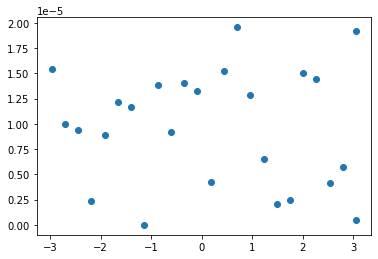

In [24]:
# ALA->THR -- THR at lambda = 0
torsion_scans.append(run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29])) # for 7/31
# run_torsion_scan(htf, 0, False, [6, 8, 10, 27], [6, 8, 10, 18], [22, 23, 24, 25, 26, 28]) # for 7/5

60.501450299496824


100%|██████████| 10000/10000 [00:01<00:00, 9406.65it/s]


1.0471988
nan


INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000111 radians
INFO:root:Rotating by 0.2619999999999889 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000323 radians
INFO:root:Rotating by 0.261

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
raw d: {1.30919877243042: (nan, nan), 1.57119877243042: (nan, nan), 1.83319877243042: (nan, nan), 2.09519877243042: (nan, nan), 2.35719877243042: (nan, nan), 2.61919877243042: (nan, nan), 2.88119877243042: (nan, nan), -3.1399865347491662: (nan, nan), -2.877986534749166: (nan, nan), -2.615986534749166: (nan, nan), -2.353986534749166: (nan, nan), -2.091986534749166: (nan, nan), -1.8299865347491662: (nan, nan), -1.5679865347491662: (nan, nan), -1.3059865347491662: (nan, nan), -1.0439865347491661: (nan, nan), -0.7819865347491661: (nan, nan), -0.5199865347491661: (nan, nan), -0.2579865347491661: (nan, nan), 0.004013465250833903: (nan, nan), 0.2660134652508339: (nan, nan), 0.5280134652508339: (nan, nan), 0.7900134652508339: (nan, nan), 1.052013465250834: (nan, nan), 1.314013465250834: (nan, nan)}
min: nan
d corrected: {1.30919877243042: (nan, nan), 1.57119877243042: (nan, nan), 1.83319877243042: (

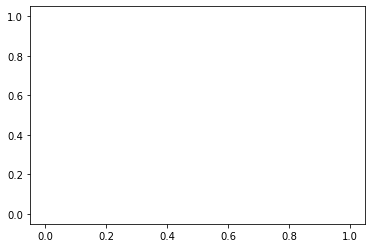

{1.30919877243042: (nan, nan),
 1.57119877243042: (nan, nan),
 1.83319877243042: (nan, nan),
 2.09519877243042: (nan, nan),
 2.35719877243042: (nan, nan),
 2.61919877243042: (nan, nan),
 2.88119877243042: (nan, nan),
 -3.1399865347491662: (nan, nan),
 -2.877986534749166: (nan, nan),
 -2.615986534749166: (nan, nan),
 -2.353986534749166: (nan, nan),
 -2.091986534749166: (nan, nan),
 -1.8299865347491662: (nan, nan),
 -1.5679865347491662: (nan, nan),
 -1.3059865347491662: (nan, nan),
 -1.0439865347491661: (nan, nan),
 -0.7819865347491661: (nan, nan),
 -0.5199865347491661: (nan, nan),
 -0.2579865347491661: (nan, nan),
 0.004013465250833903: (nan, nan),
 0.2660134652508339: (nan, nan),
 0.5280134652508339: (nan, nan),
 0.7900134652508339: (nan, nan),
 1.052013465250834: (nan, nan),
 1.314013465250834: (nan, nan)}

In [51]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf, 1, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13]) # for 7/31
# run_torsion_scan(htf, 1, True, [6, 8, 10, 15], [6, 8, 10, 11], [11, 12]) # for 7/5

###  Generate torsion scans for vanilla htf with 4 flattened exceptions and all torsions (sidechains not mapped): THR->ALA

In [40]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/6/"
with open(os.path.join(outdir, "6_vacuum.pickle" ), "rb") as f:
    htf_at = pickle.load(f)

In [8]:
old_system = htf_at._topology_proposal.old_system
new_system = htf_at._topology_proposal.new_system

In [9]:
for i in range(htf_at._topology_proposal.new_system.getNumForces()):
    print(i, htf_at._topology_proposal.new_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b24e9ba6480> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b24e9ba6480> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b24e9ba6480> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b24e9ba6480> >


In [10]:
for atom in htf_at.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB2 11
ALA2-HB3 12
ALA2-C 13
ALA2-O 14
ALA2-HB1 15
ALA2-HB 22
ALA2-CG2 23
ALA2-HG21 24
ALA2-HG22 25
ALA2-HG23 26
ALA2-OG1 27
ALA2-HG1 28
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [11]:
# # Flatten all 1,4s
# nb_force = old_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [12]:
# Flatten all 1,4s
# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         if p1 == 11 or p2 == 11:
#             print(nb_force.getExceptionParameters(i))
#             nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if abs(p1-p2) == 3:
#         if p1 == 11 and p2 == 14:
#             print(nb_force.getExceptionParameters(i))
#             nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [13]:
# # Flatten more torsions (for all atoms)
# periodic_torsion = old_system.getForce(2)
# for i in range(periodic_torsion.getNumTorsions()):
#     p1, p2, p3, p4, periodicity, phase, k = periodic_torsion.getTorsionParameters(i)
#     periodic_torsion.setTorsionParameters(i, p1, p2, p3, p4, periodicity, phase, 0.*k)

In [14]:
# # Flatten more torsions (for all atoms)
# periodic_torsion = new_system.getForce(2)
# for i in range(periodic_torsion.getNumTorsions()):
#     p1, p2, p3, p4, periodicity, phase, k = periodic_torsion.getTorsionParameters(i)
#     periodic_torsion.setTorsionParameters(i, p1, p2, p3, p4, periodicity, phase, 0.*k)

In [15]:
# # Flatten sterics, electrostatics
# nb_force = old_system.getForce(3)
# for i in range(nb_force.getNumParticles()):
#     chargeProd, sigma, epsilon = nb_force.getParticleParameters(i)
#     nb_force.setParticleParameters(i, 0, sigma, 0)

# # Flatten all exceptions
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

In [17]:
# off = list(range(0, 8)) + list(range(16, 23)) # no energy barrier
# off = list(range(0, 8)) # Still has somewhat high energy barrier, multiple minima
# off = list(range(16, 23)) # Still has somewhat high energy barrier
# off = [1, 6, 16, 18] # no energy barrier
# off = [1, 6, 18] # no energy barrier
# off = [1, 18] # energy barrier
# off = [6, 18] # no energy barrier
off = [6] # no energy barrier


# # Flatten sterics, electrostatics
nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumParticles()):
# #     print(i, nb_force.getParticleParameters(i))
#     if i in off:
#         print(i, nb_force.getParticleParameters(i))
#         chargeProd, sigma, epsilon = nb_force.getParticleParameters(i)
#         nb_force.setParticleParameters(i, 0, sigma, 0)
        


print()
print()

off_pairs = [(6, 14), (6, 18), (11,18)]

# Flatten all exceptions
for i in range(nb_force.getNumExceptions()):
#     print(i, nb_force.getExceptionParameters(i))
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     if p1 in off or p2 in off:
    if (p1, p2) in off_pairs:
        if chargeProd.value_in_unit_system(unit.md_unit_system) != 0 or epsilon.value_in_unit_system(unit.md_unit_system) != 0:
            print(i, nb_force.getExceptionParameters(i))
            nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)
        



55 [6, 14, Quantity(value=0.08445638333333334, unit=elementary charge**2), Quantity(value=0.3324834016099747, unit=nanometer), Quantity(value=0.28529542140034425, unit=kilojoule/mole)]
76 [6, 18, Quantity(value=0.23421230833333337, unit=elementary charge**2), Quantity(value=0.31582359558075035, unit=nanometer), Quantity(value=0.3956480308961489, unit=kilojoule/mole)]
80 [11, 18, Quantity(value=-0.33652877500000006, unit=elementary charge**2), Quantity(value=0.32330714481312917, unit=nanometer), Quantity(value=0.2814062724986776, unit=kilojoule/mole)]


In [19]:
# Build new htf
from perses.tests.test_topology_proposal import generate_atp
htf_at._topology_proposal._old_system = old_system
htf_at._topology_proposal._new_system = new_system

from perses.annihilation.relative import HybridTopologyFactory
htf = HybridTopologyFactory(topology_proposal=htf_at._topology_proposal,
                     current_positions=htf_at.old_positions(htf_at.hybrid_positions),
                     new_positions=htf_at.new_positions(htf_at.hybrid_positions),
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=False,
                     omitted_terms=None,
                     flatten_torsions=True)

RDKit WARNING: [20:27:30] Enabling RDKit 2019.09.3 jupyter extensions
INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating ol

In [61]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB2) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB3) of chain 0 residue 1 (ALA)> 12
<Atom 13 (C) of chain 0 residue 1 (ALA)> 13
<Atom 14 (O) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB1) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [62]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

 18%|█▊        | 1805/10000 [00:00<00:00, 18046.40it/s]

-96.29144459922797


100%|██████████| 10000/10000 [00:00<00:00, 19371.54it/s]


-1.1785822
-69.12299715501726


INFO:root:Rotating by 0.2620000870596926 radians
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26199999999999984 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2619999999999981 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.

-68.5189681618048
-67.22974612157658
-65.62764081198915
-64.08108079274083
-62.92684027641609
-62.29797739855901
-62.05393959170955
-61.983991385910656
-61.99817517661201
-62.12183136690693
-62.41636525189911
-62.93652324951398
-63.71545735602698
-64.74452306523328
-65.94045532292309
-67.11046225424606
-67.92790756082778
-68.01025525739742
-67.27107442331067
-66.3817170976381
-66.41728598588091
-67.54438698920517
-68.75438057164199
-69.12024860002741
raw d: {-0.9165821914672851: (-68.5189681618048, nan), -0.6545821914672851: (-67.22974612157658, nan), -0.3925821914672851: (-65.62764081198915, nan), -0.1305821914672851: (-64.08108079274083, nan), 0.1314178085327149: (-62.92684027641609, nan), 0.3934178085327149: (-62.29797739855901, nan), 0.6554178085327149: (-62.05393959170955, nan), 0.9174178085327149: (-61.983991385910656, nan), 1.179417808532715: (-61.99817517661201, nan), 1.441417808532715: (-62.12183136690693, nan), 1.703417808532715: (-62.41636525189911, nan), 1.965417808532715: 

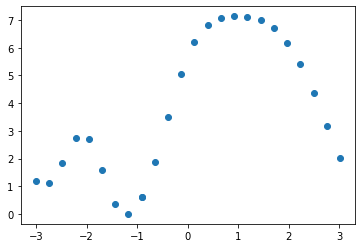

In [20]:
# ALA->THR -- THR at lambda = 0
# run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]) # for 7/31
run_torsion_scan(htf, 0, False, [6, 8, 10, 27], [6, 8, 10, 18], [22, 23, 24, 25, 26, 28]) # for 7/5

 18%|█▊        | 1809/10000 [00:00<00:00, 18088.68it/s]

172.03064520168553


100%|██████████| 10000/10000 [00:00<00:00, 19582.60it/s]


3.1412313
-34.984676240852096


INFO:root:Rotating by -3.918858996478927 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.2619999999999876 radians
INFO:root:Rotating by 0.26200000000001217 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:R

-34.74895639051981
-34.30487418963406
-33.74975779300054
-33.50776206777781
-33.813031330114896
-34.47168725562806
-35.06222332357131
-35.259815348688754
-34.923042682259556
-34.09959815865339
-33.13512936582603
-32.633151100090735
-32.962748160269776
-33.841997965427446
-34.656788555775535
-34.98637077243559
-34.707019486923826
-33.90846115789017
-32.93560646670919
-32.367633425793834
-32.60670979918413
-33.4486340532134
-34.31556870635752
-34.7857425608775
raw d: {-2.879954008732931: (-34.74895639051981, nan), -2.617954008732931: (-34.30487418963406, nan), -2.355954008732931: (-33.74975779300054, nan), -2.093954008732931: (-33.50776206777781, nan), -1.831954008732931: (-33.813031330114896, nan), -1.569954008732931: (-34.47168725562806, nan), -1.3079540087329309: (-35.06222332357131, nan), -1.0459540087329309: (-35.259815348688754, nan), -0.7839540087329309: (-34.923042682259556, nan), -0.5219540087329309: (-34.09959815865339, nan), -0.25995400873293084: (-33.13512936582603, nan), 0.0

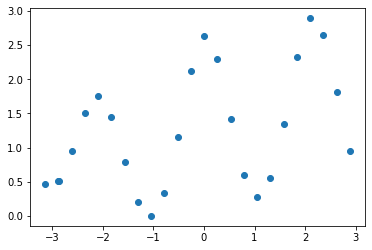

In [22]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf, 1, True, [6, 8, 10, 15], [6, 8, 10, 11], [11, 12]) # for 7/5

# Plot diff torsion scans all on one plot

In [25]:
import collections

In [26]:
len(torsion_scans)

3

In [54]:
# torsion_scans = torsion_scans[0:3] + [torsion_scans[4]]

IndexError: list index out of range

In [27]:
torsion_scans[0]

{-0.9165821914672851: (24.90849120048864, nan),
 -0.6545821914672851: (31.72519735166135, nan),
 -0.3925821914672851: (38.70757265330979, nan),
 -0.1305821914672851: (43.14097910131541, nan),
 0.1314178085327149: (42.69146217148827, nan),
 0.3934178085327149: (37.39759565828955, nan),
 0.6554178085327149: (29.667706631878737, nan),
 0.9174178085327149: (22.301548815553822, nan),
 1.179417808532715: (17.07539914082406, nan),
 1.441417808532715: (14.453747709263943, nan),
 1.703417808532715: (13.620525719919875, nan),
 1.965417808532715: (12.793723846260555, nan),
 2.227417808532715: (10.353570434423219, nan),
 2.489417808532715: (6.279393868194276, nan),
 2.751417808532715: (2.202353457761177, nan),
 3.013417808532715: (0.0, nan),
 -3.007767498646871: (0.6197544970167286, nan),
 -2.745767498646871: (3.793808485493173, nan),
 -2.483767498646871: (8.25427084714238, nan),
 -2.221767498646871: (12.302692473142876, nan),
 -1.9597674986468712: (14.79420444358135, nan),
 -1.6977674986468712: (

In [28]:
torsion_scans_sorted = []
for scan in torsion_scans:
    torsion_scans_sorted.append(collections.OrderedDict(sorted(scan.items())))

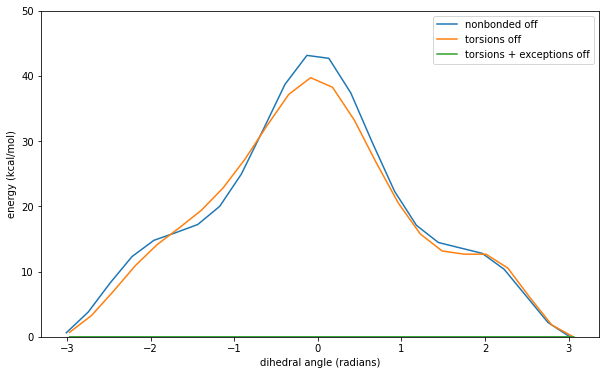

In [36]:
labels = ['nonbonded off', 'torsions off', 'torsions + exceptions off']

fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(list(torsion_scans_sorted[0].keys()), [mean for mean, stderr in list(torsion_scans_sorted[0].values())], label=labels[0])
# ax.plot(list(torsion_scans_sorted[1].keys()), [mean for mean, stderr in list(torsion_scans_sorted[1].values())], label=labels[1])
# ax.plot(list(torsion_scans_sorted[2].keys()), [mean for mean, stderr in list(torsion_scans_sorted[2].values())], label=labels[2])

for i in range(len(torsion_scans)):
    ax.plot(list(torsion_scans_sorted[i].keys()), [mean for mean, stderr in list(torsion_scans_sorted[i].values())], label=labels[i])

ax.set(xlabel='dihedral angle (radians)', ylabel='energy (kcal/mol)')
ax.legend(loc='upper right')
ax.set_ylim([0, 50])
plt.show()